# Дипомный проект Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.  

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.  

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.  

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.  

### Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

Таблица ***steel.data_arc***

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

Таблица ***steel.data_bulk***

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

Таблица ***steel.data_bulk_time***

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

Таблица ***steel.data_gas***

- key — номер партии;
- gas — объём подаваемого газа.

Таблица ***steel.data_temp***

- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

Таблица ***steel.data_wire***

- key — номер партии;
- Wire1 … Wire15 — объём подаваемых проволочных материалов.

Таблица ***steel.data_wire_time***

-key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подключение библиотек и выгрузка данных

Подклбчамем необхожимые бибиотеки и заводим глобальные переменные.

In [389]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR

from catboost import CatBoostRegressor as CBR

import torch.nn as nn
import torch

import matplotlib.pyplot as plt

In [255]:
RANDOM_STATE = 5062023
PATH = './data/'

Подлкючаемся к базе данных и оцениваем размеры таблиц.

In [256]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [257]:
for i in ['steel.data_arc','steel.data_bulk','steel.data_bulk_time','steel.data_gas','steel.data_temp','steel.data_wire','steel.data_wire_time']:
    query = f'''
    SELECT *
    FROM {i}
    '''
    print('-------------------------------------------------------------')
    print(pd.read_sql_query(sql=text(query), con = engine.connect()).info())

-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 n

Как видим все таблици на месте и они имеют разное количесвто данных и прежде чем их обединять в одну большую, нужно порабоать с каждой по отдельности. 

## Первичный анализ

## data_arc

Начнем с таблицы `data_arc`, выгрузим ее и поработам с каждыйм столбцом.

In [258]:
def get_info(df):
    display(df.info())
    display(df.sample(5))

In [259]:
query = f'''
SELECT *
FROM steel.data_arc
'''
data_arc = pd.read_sql_query(sql=text(query), con = engine.connect())


In [260]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
11661,2544,16:19:28,16:22:04,0.516641,0.471219
446,96,17:28:41,17:31:11,0.610526,0.486984
472,101,21:10:21,21:12:20,0.494582,0.356622
3148,682,14:30:49,14:38:23,1.833491,1.633180
3512,760,17:00:03,17:02:07,0.505054,0.358122


На первый взгляд проблем больших нету, нету пропусков, но лучше перевести столбцы `BeginHeat` и `EndHeat` в формат времени и в итоге получить от них продолжительность нагрева, эта информация важнее.

Что касается мощности то тдумаю нам важнее получить полную мощность потребления, для жтого есть формула  

    sqr(`ActivePower`^2 + `ReactivePower`^2)

воспользуемся ей.

### Столбцы времени.

По скольку столбцы имеют отдин формат, hh:mm:ss проще будем воспользоваться этим и просто написать функцию для пересчета времени, чем по нескольку раз менять формат.

In [261]:
data_arc.loc[0,'EndHeat']

datetime.time(11, 6, 2)

Новая водная, как видно эти столбцы имеют формат `datetime`, по жтому можно просто вычесть один из другого. Так же поскольку это формат `datetime` то и аномалий со временем быть не должно.

In [262]:
def get_seconds(df):
    return ((df['EndHeat'].hour - df['BeginHeat'].hour)*60*60 +
            (df['EndHeat'].minute - df['BeginHeat'].minute)*60 +
            (df['EndHeat'].second - df['BeginHeat'].second))

In [263]:
data_arc['TimeHeat'] = data_arc.apply(get_seconds,axis=1)

In [264]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
 5   TimeHeat       14876 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 697.4+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
6323,1375,01:04:15,01:06:14,0.495692,0.351515,119
8646,1881,10:21:28,10:26:45,1.425448,1.019619,317
10583,2300,02:20:38,02:23:53,0.848068,0.669578,195
10599,2304,05:01:03,05:03:52,0.672970,0.452359,169
1221,268,09:17:44,09:21:05,0.787244,0.592254,201


Осталось убедиться что `TimeHeat` не имеет отрицательных значений. Поскольку вогут быть моменты когда, нагрев наичналя в конце дня и заканчивался уже посе полуночи.

In [265]:
data_arc.loc[data_arc['TimeHeat'] <= 0, ['BeginHeat','EndHeat','TimeHeat']]

,BeginHeat,EndHeat,TimeHeat
580,23:59:35,00:01:55,-86260
1170,23:58:57,00:00:07,-86330
1280,23:56:57,00:01:43,-86114
1953,23:58:33,00:01:57,-86196
2952,23:52:55,00:03:13,-85782
3438,23:58:27,00:00:14,-86293
4250,23:58:22,00:01:34,-86208
4752,23:59:04,00:07:07,-85917
5400,23:59:25,00:05:07,-86058
6456,23:56:33,00:01:05,-86128


Как я и предполагал, есть отрицательные значения, из-за оцончания нагрева уже в новом дне. Для решения данной проблемы, нужно просто к этим значениям прибавить полный день в секундах.

In [266]:
data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat'] = data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat'] + (24*60*60)

In [267]:
data_arc.loc[data_arc['TimeHeat'] <= 0, 'TimeHeat']

Series([], Name: TimeHeat, dtype: int64)

Теперь все отлично, можно переходить к мощности.

### Мощность.

Как я уже говорил ранее, первое что можно сделать это расчитать полную мощность. Так же можнот добавить отношение активной мощности к реактивной. Кажется этих параметров нам хватит.

Но пержде посмотрим на столбцы, есть ли в них аномалии.

In [268]:
data_arc['ActivePower'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: ActivePower, dtype: float64

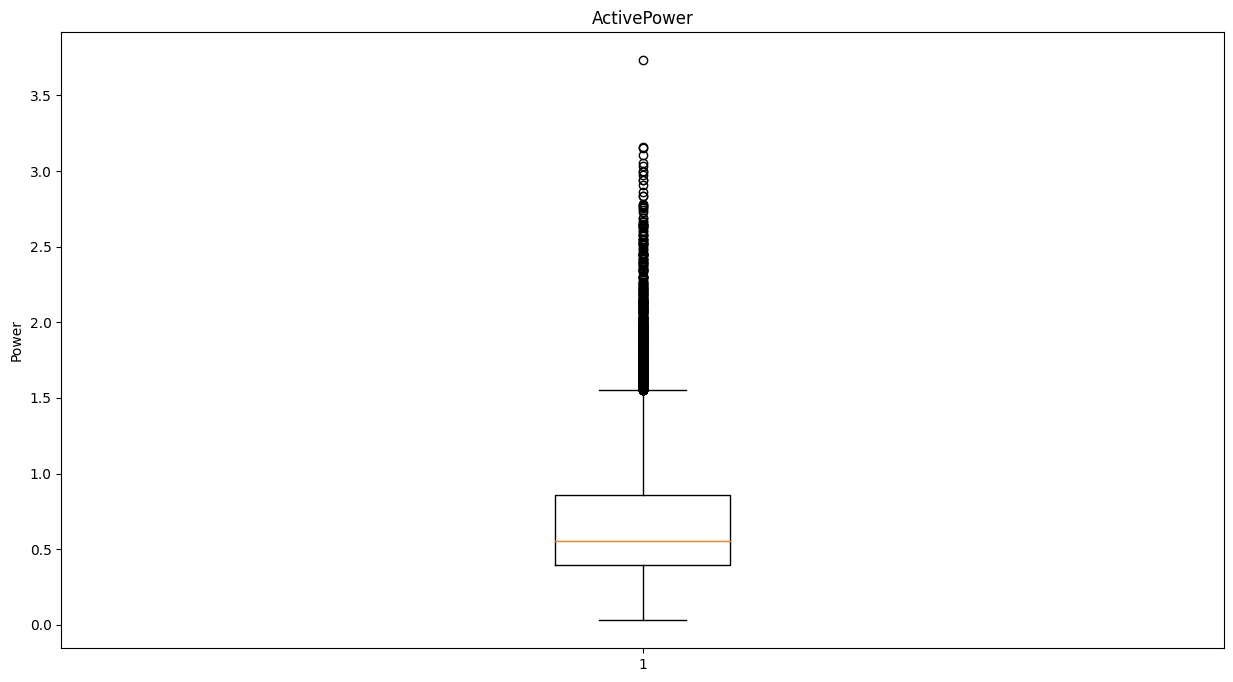

In [269]:
plt.figure(figsize=(15,8))
plt.title('ActivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ActivePower'])
plt.show()

Как видно 75% значений меньше 0.9, все что выше нельзя считать выбросами, так как мощность нагрева на прямую зависит от состава сплава и его объема, по этому все значения можно остваить.

In [270]:
data_arc['ReactivePower'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: ReactivePower, dtype: float64

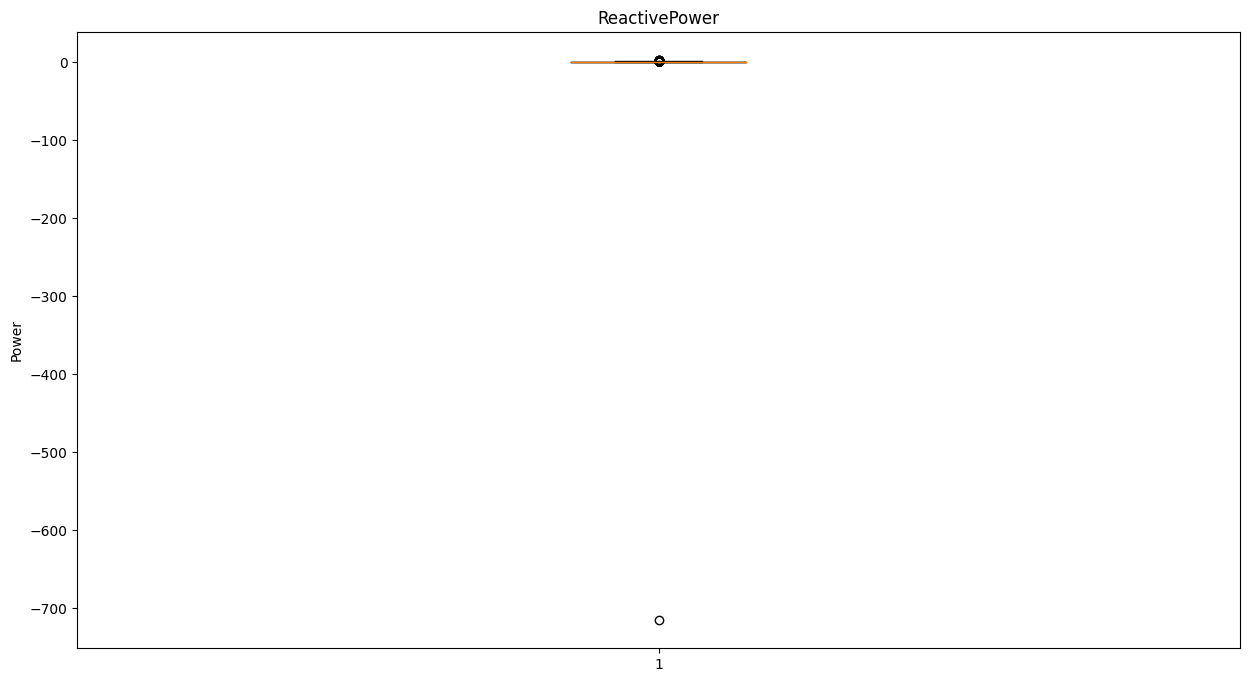

In [271]:
plt.figure(figsize=(15,8))
plt.title('ReactivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ReactivePower'])
plt.show()

In [272]:
data_arc.loc[data_arc['ReactivePower'] < -700]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109


In [273]:
data_arc.loc[data_arc['key'] == 2116]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat
9779,2116,00:29:52,00:31:54,0.433266,0.306141,122
9780,2116,00:35:50,00:38:05,0.620265,0.408352,135
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109
9782,2116,00:51:51,00:52:58,0.299368,0.198796,67


У нас есть всего один выброс, его конечно можно заменить, но лучше просто убрать эту партию, потерять 4 значения на 14000, не страшно.

In [274]:
data_arc = data_arc.loc[data_arc['key'] != 2116].reset_index(drop=True)

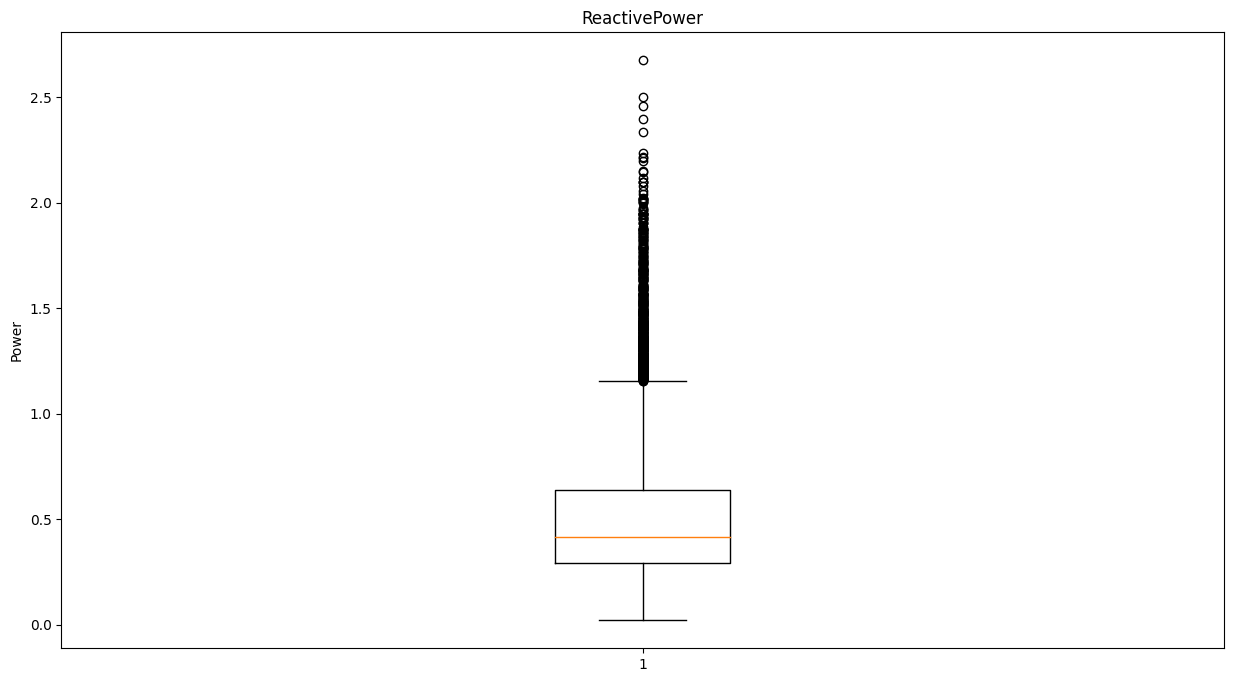

In [275]:
plt.figure(figsize=(15,8))
plt.title('ReactivePower')
plt.ylabel("Power")
plt.boxplot(data_arc['ReactivePower'])
plt.show()

Теперь тут картина как на активной мощности. Теперь можно создавать новые признаки.

In [276]:
data_arc['Power'] = np.sqrt(data_arc['ActivePower']*data_arc['ActivePower'] + 
                              data_arc['ReactivePower']*data_arc['ReactivePower'])

In [277]:
data_arc['RatioPower'] = data_arc['ReactivePower']/data_arc['ActivePower']

In [278]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   BeginHeat      14872 non-null  object 
 2   EndHeat        14872 non-null  object 
 3   ActivePower    14872 non-null  float64
 4   ReactivePower  14872 non-null  float64
 5   TimeHeat       14872 non-null  int64  
 6   Power          14872 non-null  float64
 7   RatioPower     14872 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 929.6+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
7322,1589,12:16:24,12:19:32,0.838256,0.558596,188,1.007325,0.666379
1353,294,09:18:07,09:20:06,0.436988,0.267992,119,0.512619,0.613271
1449,314,01:26:15,01:28:21,0.384919,0.270553,126,0.470491,0.702882
2207,473,21:21:09,21:23:10,0.418564,0.300711,121,0.515386,0.718433
11966,2604,19:31:48,19:33:14,0.300868,0.212722,86,0.368472,0.707027


Посмотрим, бывают ли моменты когда реактивная мощность больше активной.

In [279]:
data_arc.loc[data_arc['RatioPower'] > 1]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
40,10,16:14:58,16:19:15,0.844976,0.853738,257,1.201188,1.010370
144,32,11:40:45,11:43:53,0.560580,0.582463,188,0.808402,1.039035
439,95,16:41:07,16:45:01,0.718904,0.719138,234,1.016849,1.000325
440,95,16:51:58,16:54:16,0.386017,0.457089,138,0.598281,1.184116
524,115,12:26:12,12:27:20,0.158896,0.172457,68,0.234498,1.085339
...,...,...,...,...,...,...,...,...
14759,3216,06:34:08,06:35:21,0.213120,0.239532,73,0.320617,1.123931
14760,3216,06:37:56,06:39:22,0.251099,0.322714,86,0.408895,1.285208
14761,3216,06:42:07,06:43:46,0.328448,0.376886,99,0.499921,1.147477
14762,3216,06:45:12,06:46:38,0.297922,0.345520,86,0.456226,1.159769


У не бльшого количества операций, реактивная мощность больше активной, видимо это зависит от сплава.

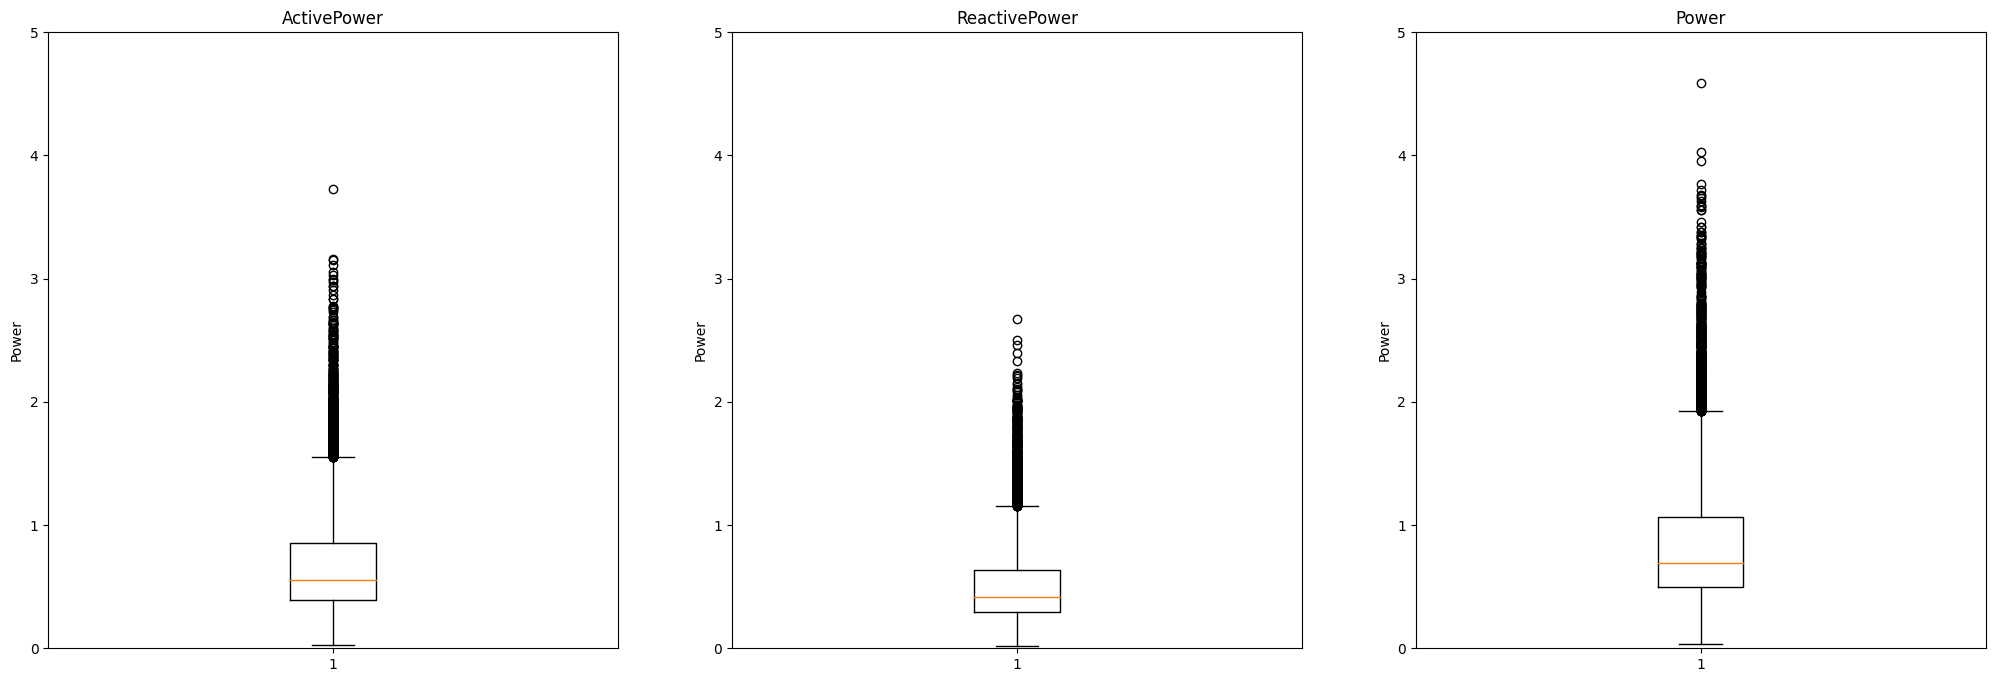

In [280]:
i = 1
fig = plt.figure(figsize=(25, 8))
for column in ['ActivePower','ReactivePower','Power']:
    fig.add_subplot(1,3,i).boxplot(data_arc[column])
    plt.ylim(0,5)
    plt.ylabel("Power")
    plt.title(f"{column}")
    i += 1

Как видно из "коробок с усами" распределение мощности очень похожи, значит и "выбросы" болше 75% не являются выбросами, а просто особенности спалва.

## data_bulk

In [281]:
query = f'''
SELECT *
FROM steel.data_bulk
'''
data_bulk = pd.read_sql_query(sql=text(query), con = engine.connect())

In [282]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
950,995,NaN,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,102.0,104.0
698,731,NaN,NaN,NaN,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.0,NaN,211.0,203.0
1303,1355,NaN,NaN,141.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412.0,NaN,225.0,204.0
1279,1330,33.0,NaN,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,622.0,NaN,261.0,220.0
413,439,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,461.0,NaN,268.0,154.0


Как видно тут есть очень много пропусков, эти пропуски означают что данный тип материала не подавался. Можно проверить совпадает ли количество итерций в таблице data_arc с количеством добавлений материалов.

In [283]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
0,1,11:02:14,11:06:02,0.976059,0.687084,228,1.193639,0.703937
1,1,11:07:28,11:10:33,0.805607,0.520285,185,0.959010,0.645830
2,1,11:11:44,11:14:36,0.744363,0.498805,172,0.896038,0.670110
3,1,11:18:14,11:24:19,1.659363,1.062669,365,1.970470,0.640408
4,1,11:26:09,11:28:37,0.692755,0.414397,148,0.807239,0.598188


In [284]:
table = data_arc.pivot_table(index='key',
                     values='Power',
                     aggfunc='count')

In [285]:
table['key'] = table.index

In [286]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [287]:
data_bulk['Count'] = data_bulk.notna().sum(axis=1)

In [288]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Count
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,5
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,5
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,5
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,5
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5


In [289]:
table = table.reset_index(drop=True)

In [290]:
test = pd.merge(left=data_bulk,
                right=table,
                on='key',
                how='left')

In [291]:
test

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Count,Power
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,5,5.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,5,4.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,5,5.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,5,4.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,5,5.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,5,3.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,5,8.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,4,5.0


In [292]:
test[['Count','Power']].isna().sum()

Count    0
Power    2
dtype: int64

In [293]:
sum(test['Count'] == test['Power'])

739

Как видно, не все моменты совпали, возможно были еще итерации по добавлению проволочных материалов.

In [294]:
sum(test['Count'] < test['Power'])

1179

Как видно есть итерации которых меньше чем добавления материалов, сложно сейчас сделать выводы, нужно посмотреть на остальные таблицы.

Посмотрм на аномалии по столбцам.

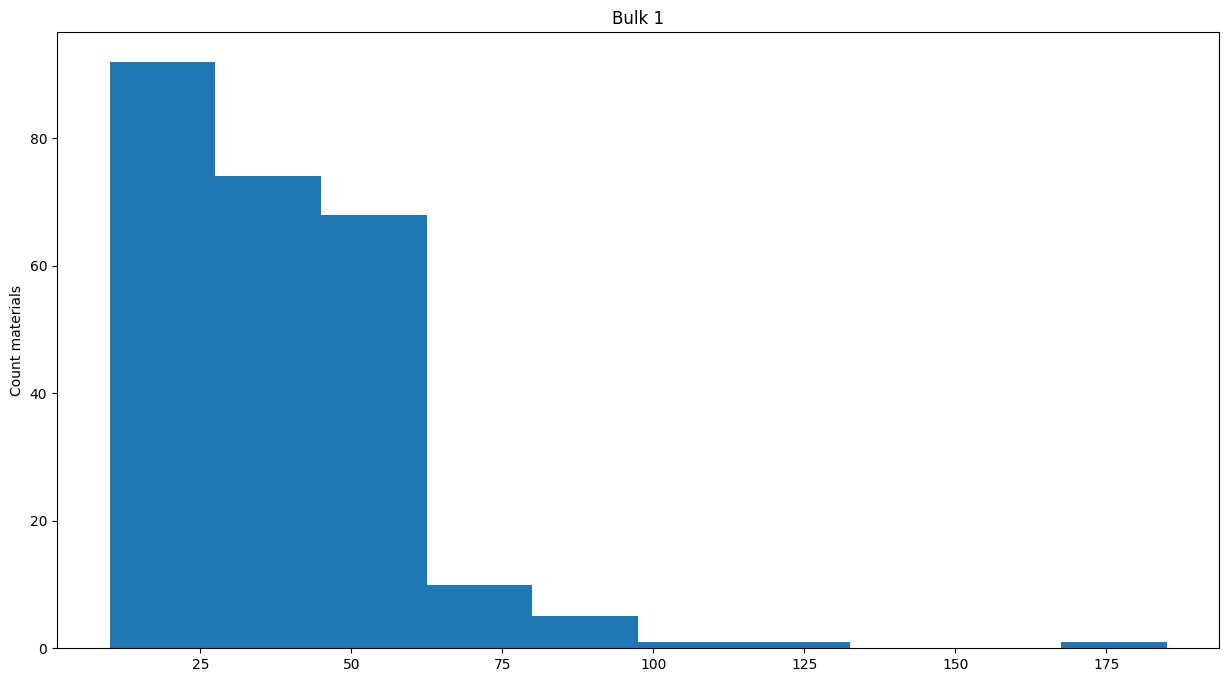

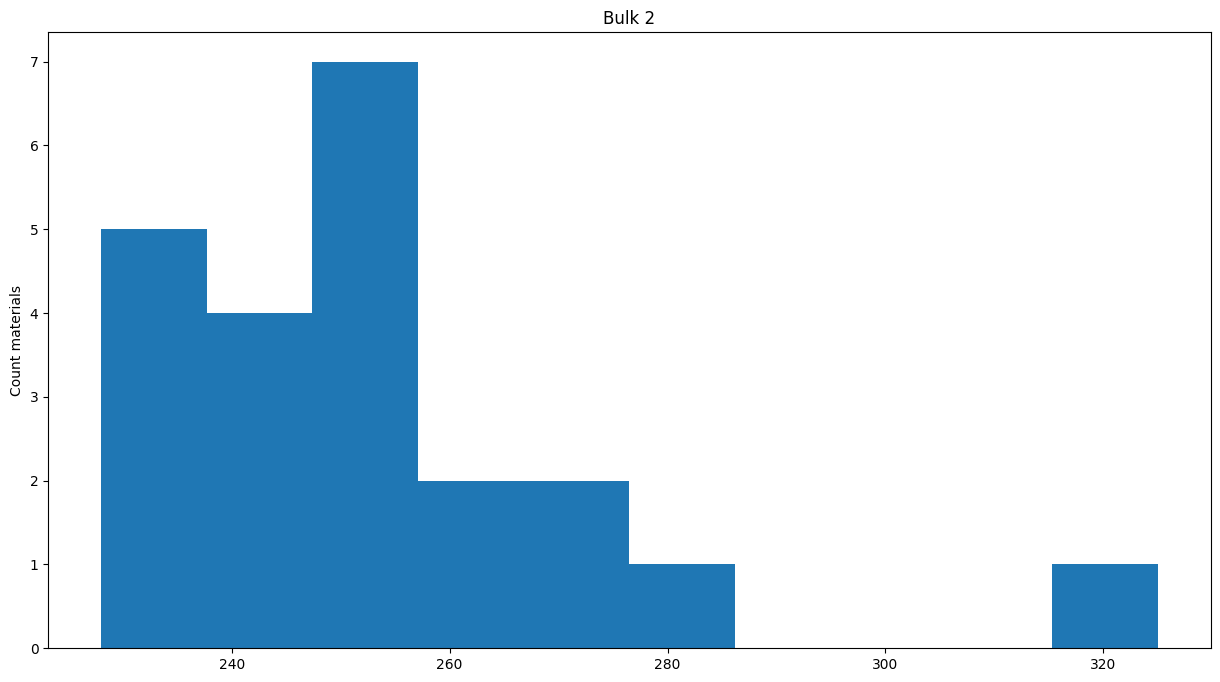

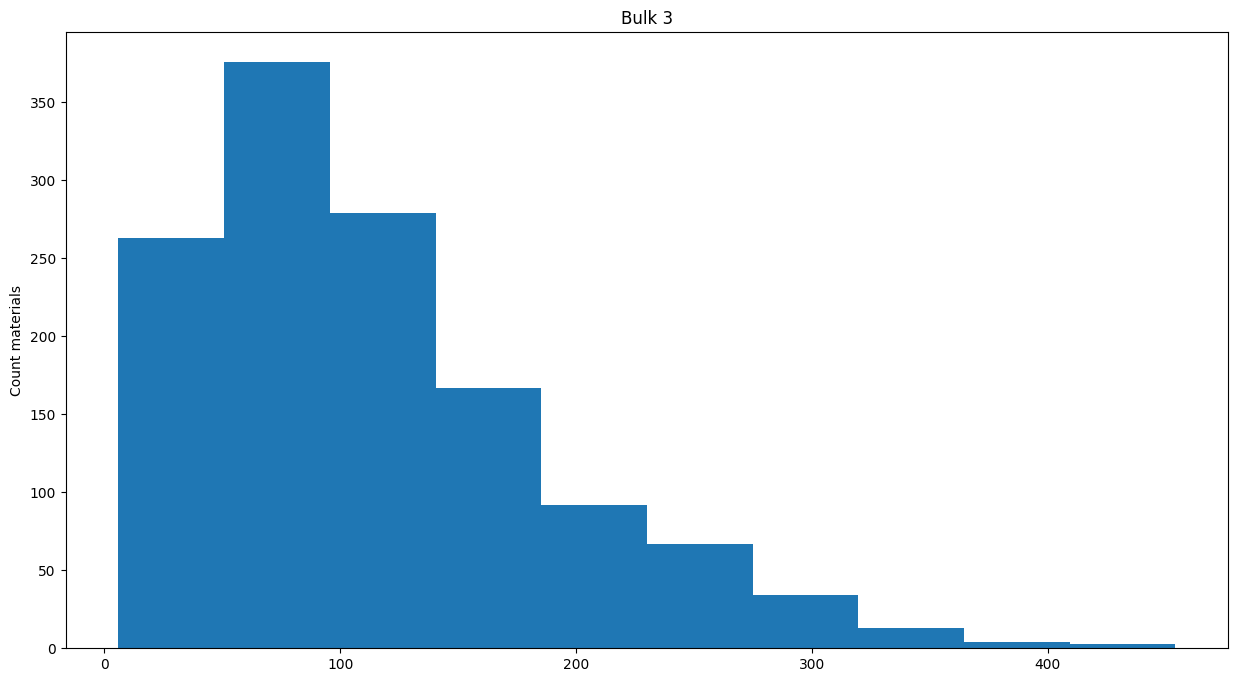

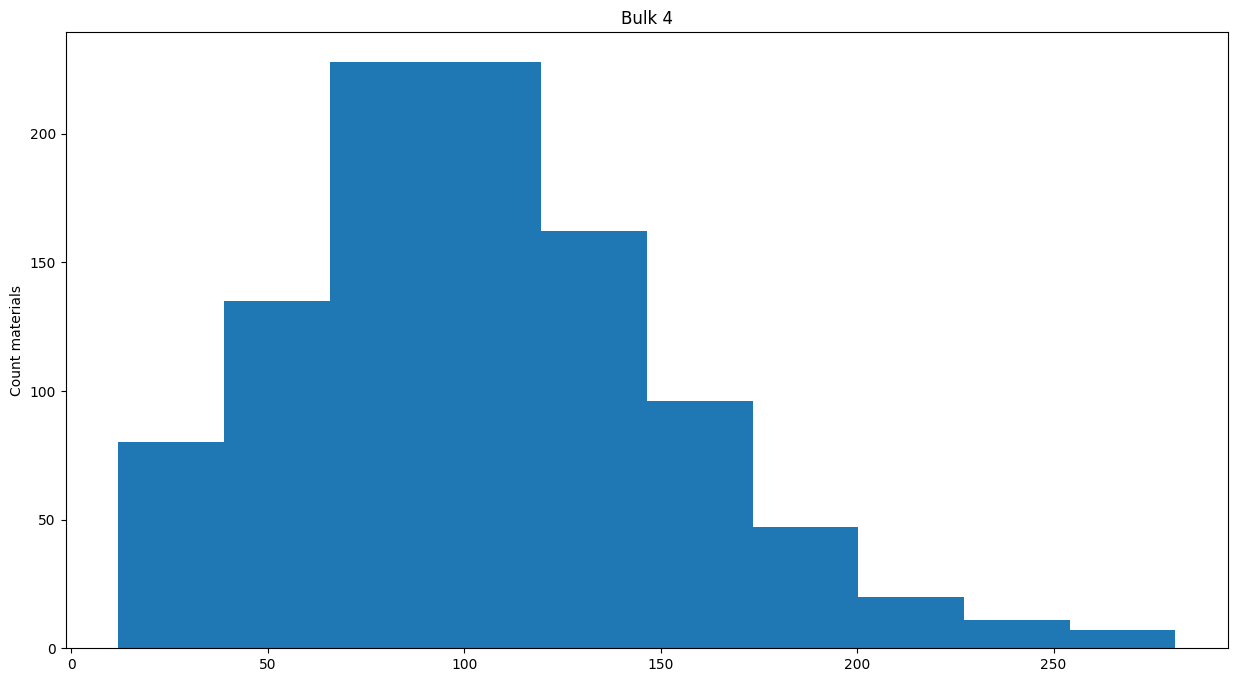

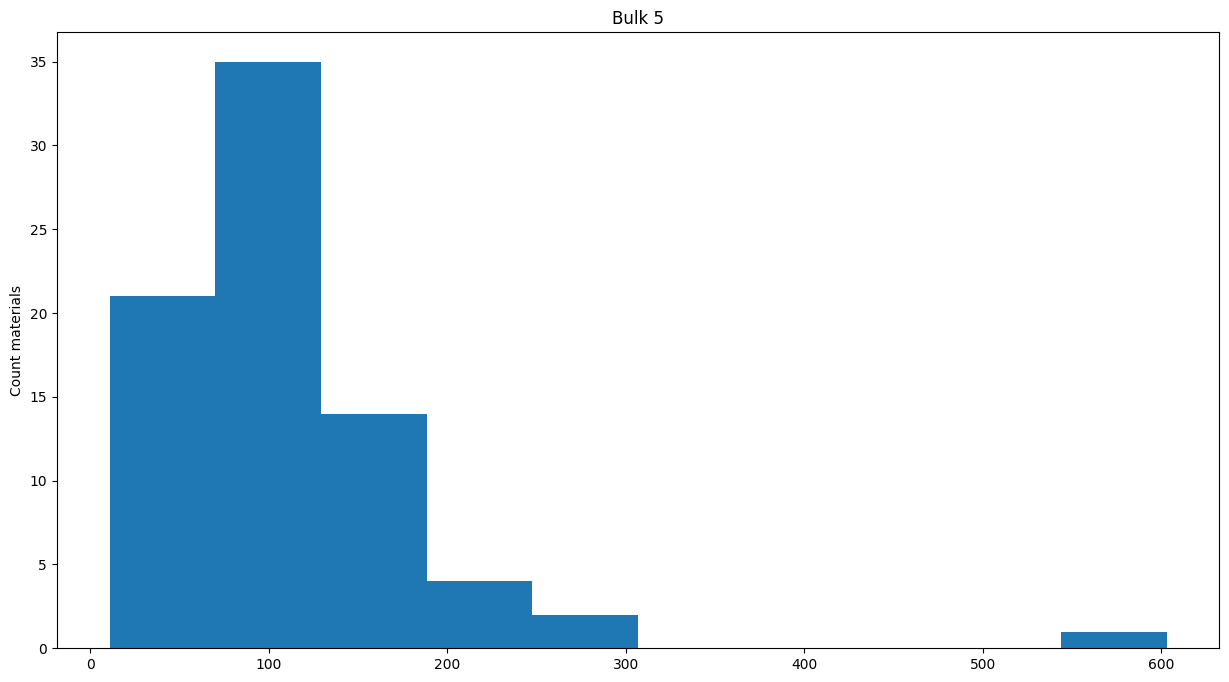

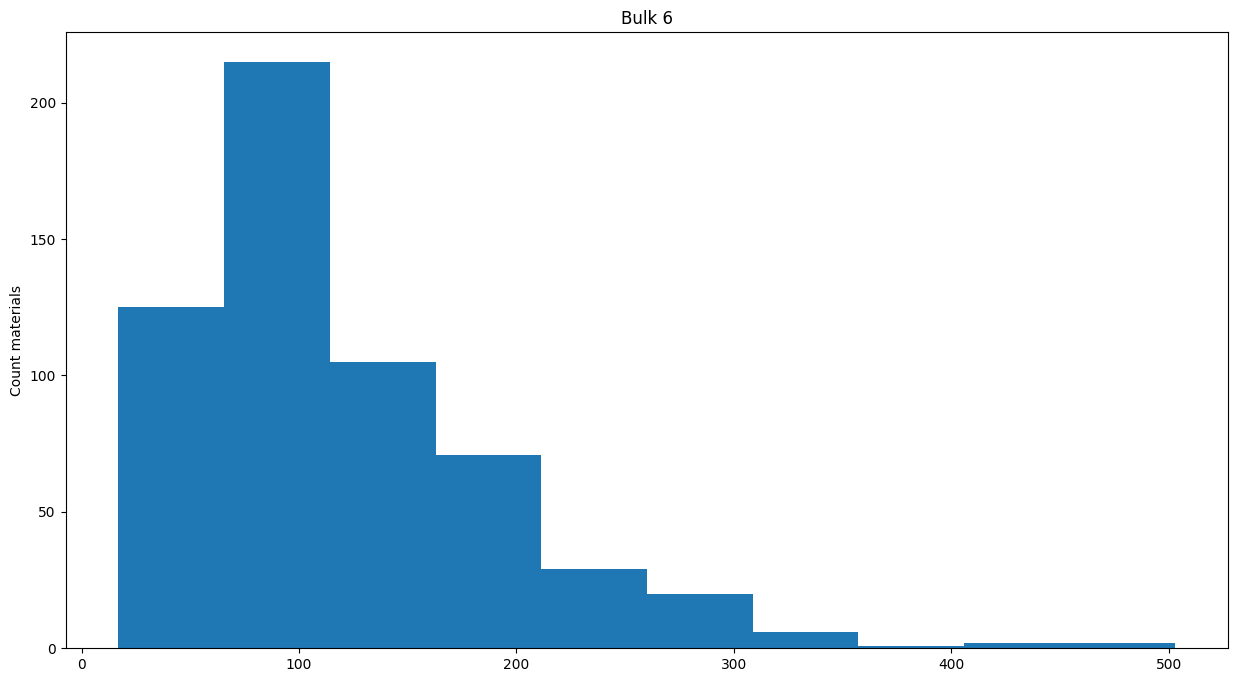

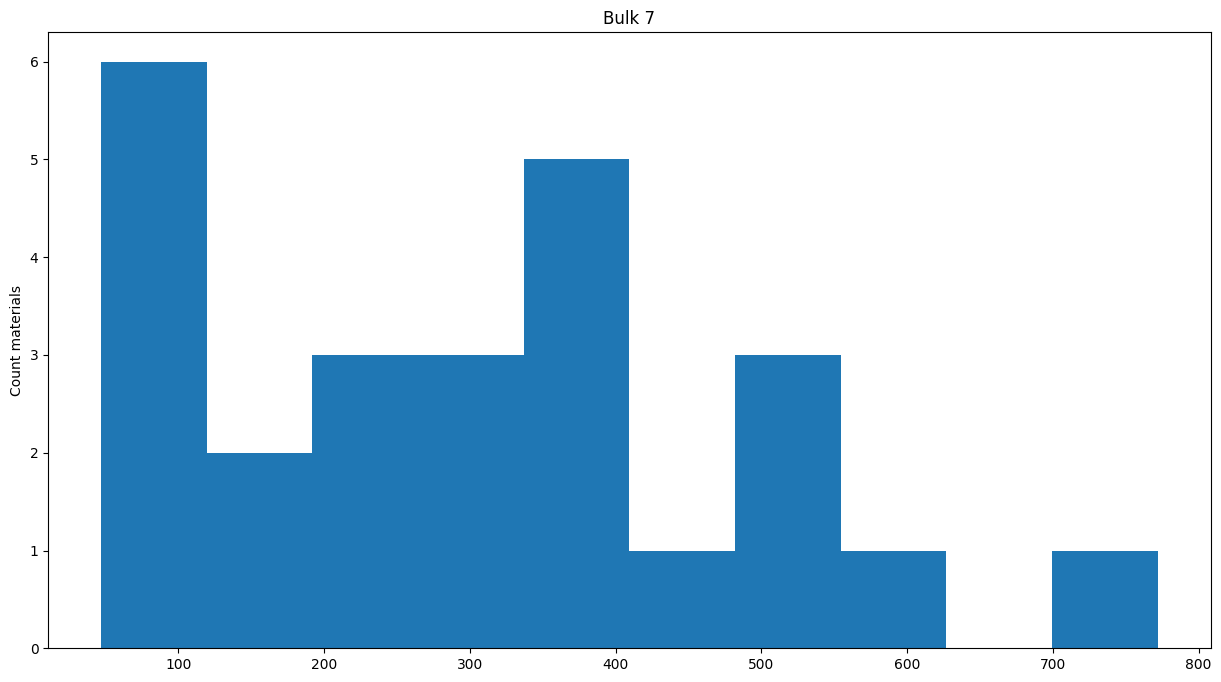

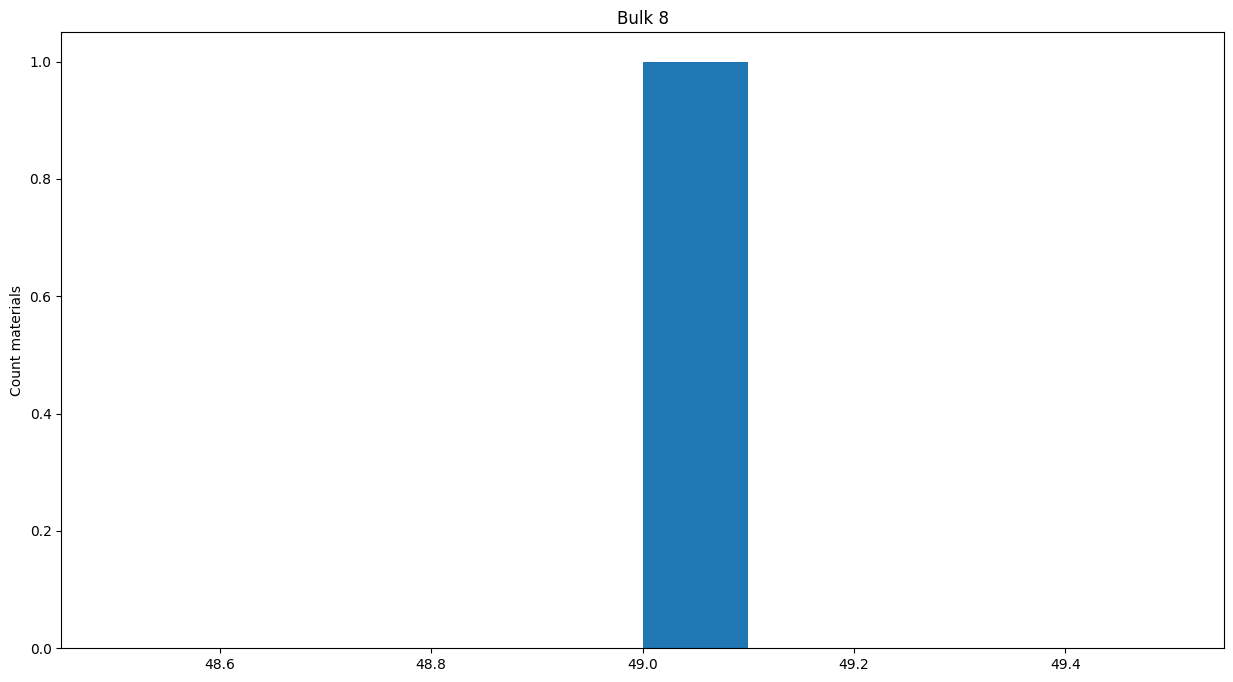

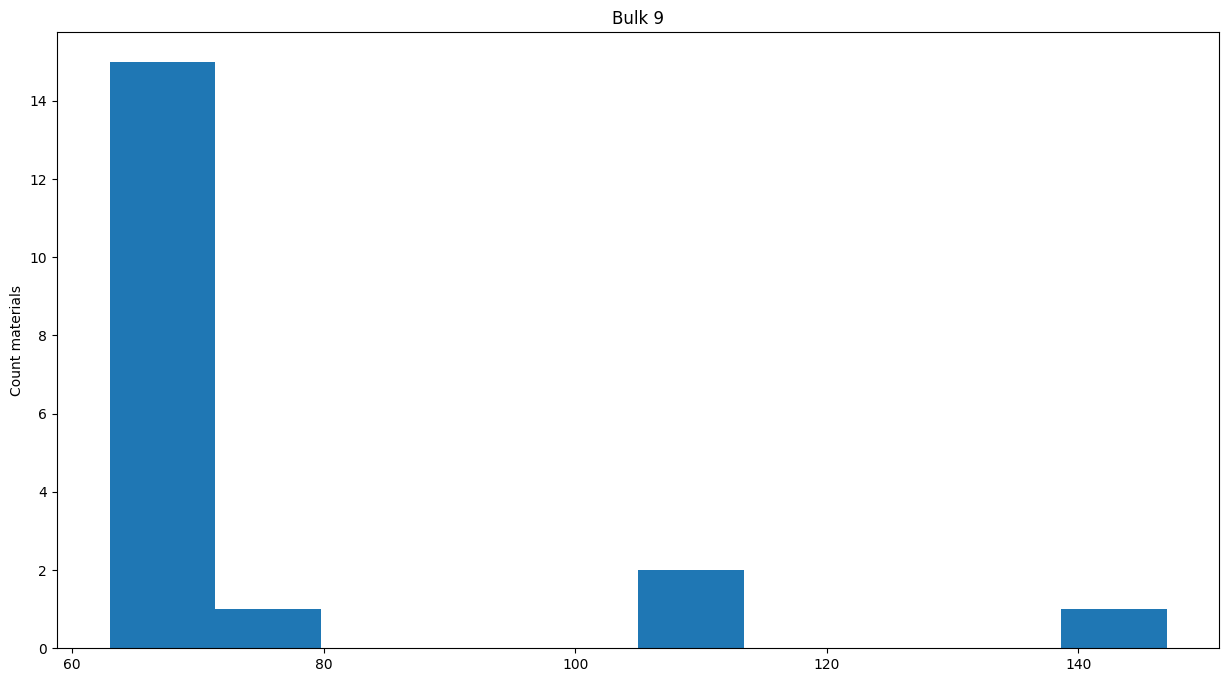

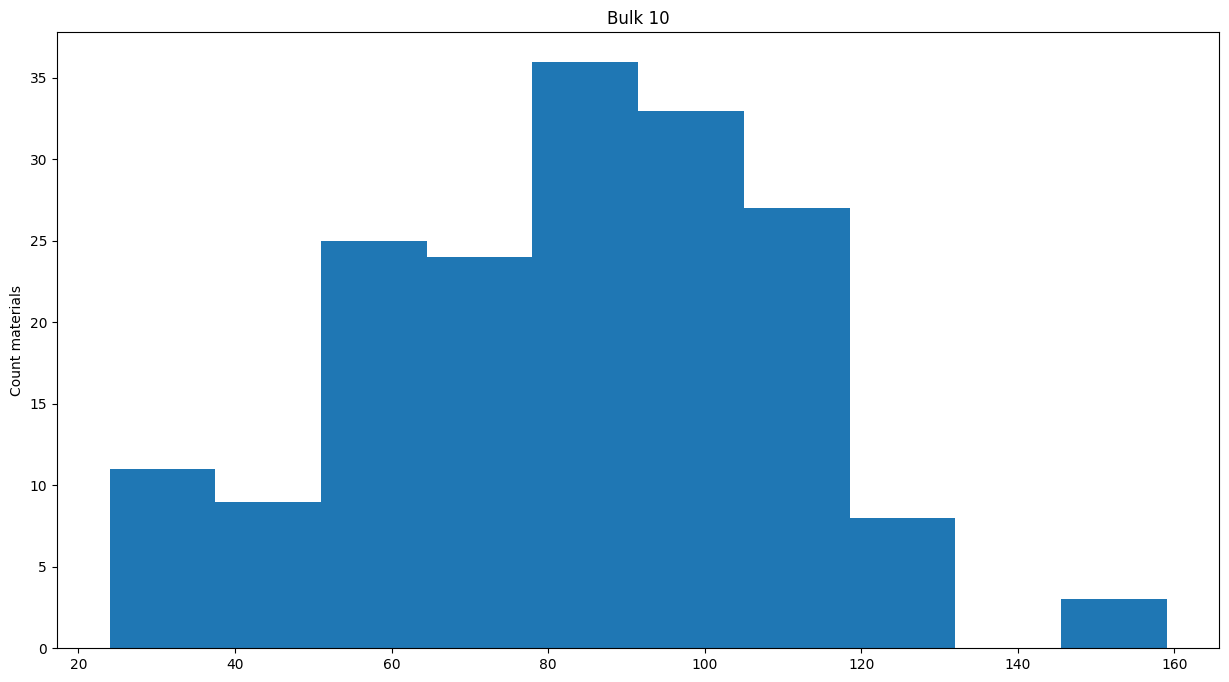

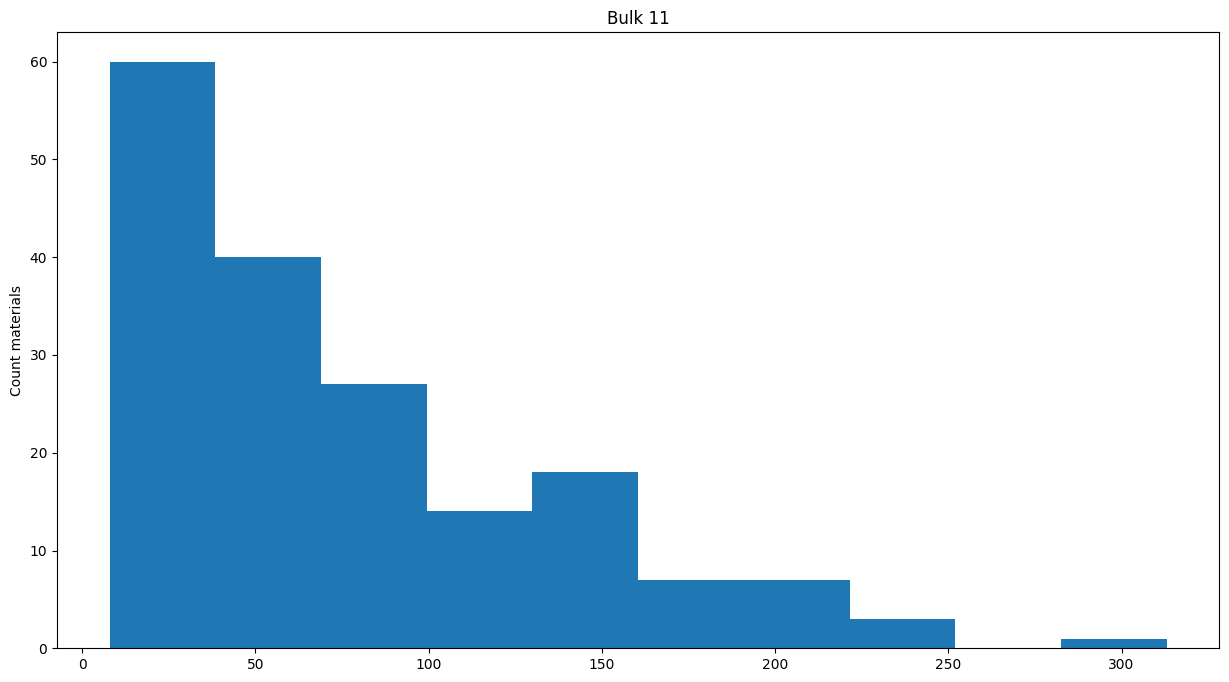

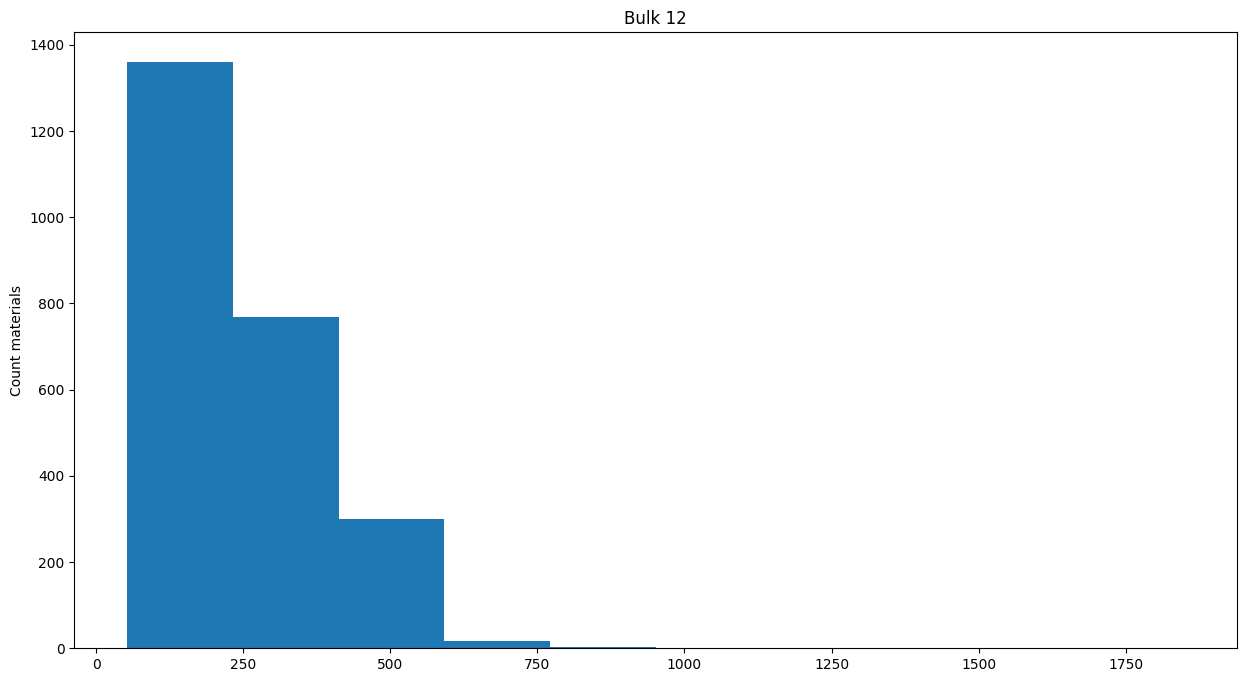

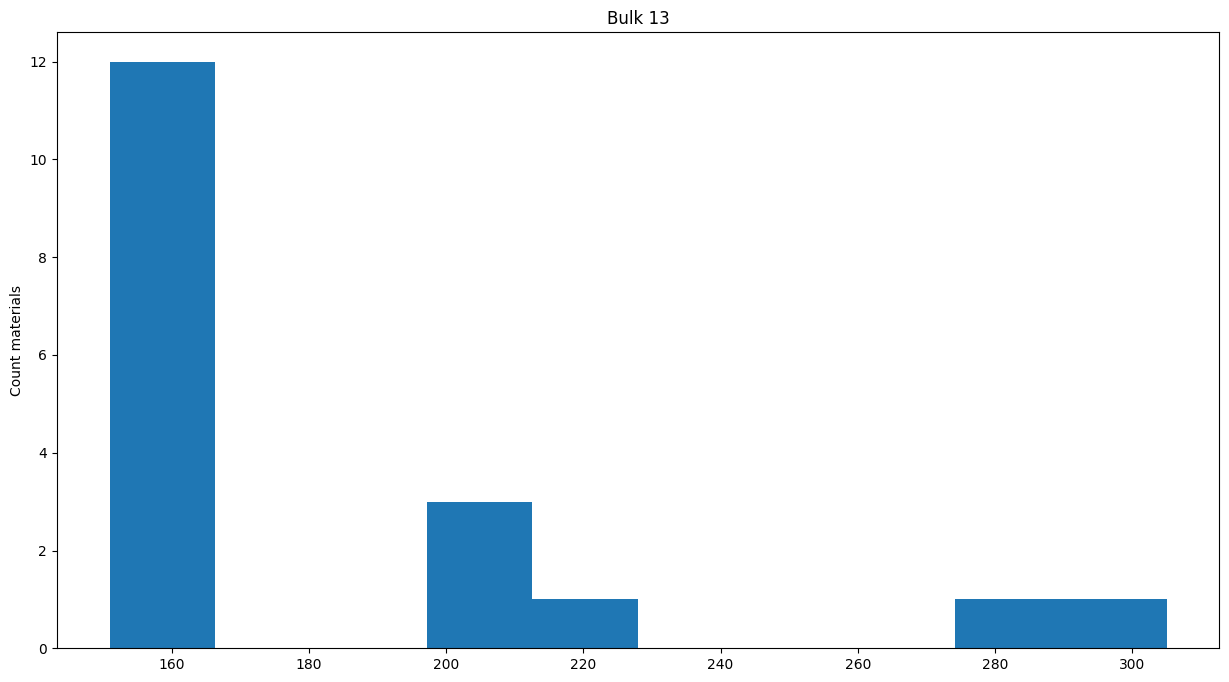

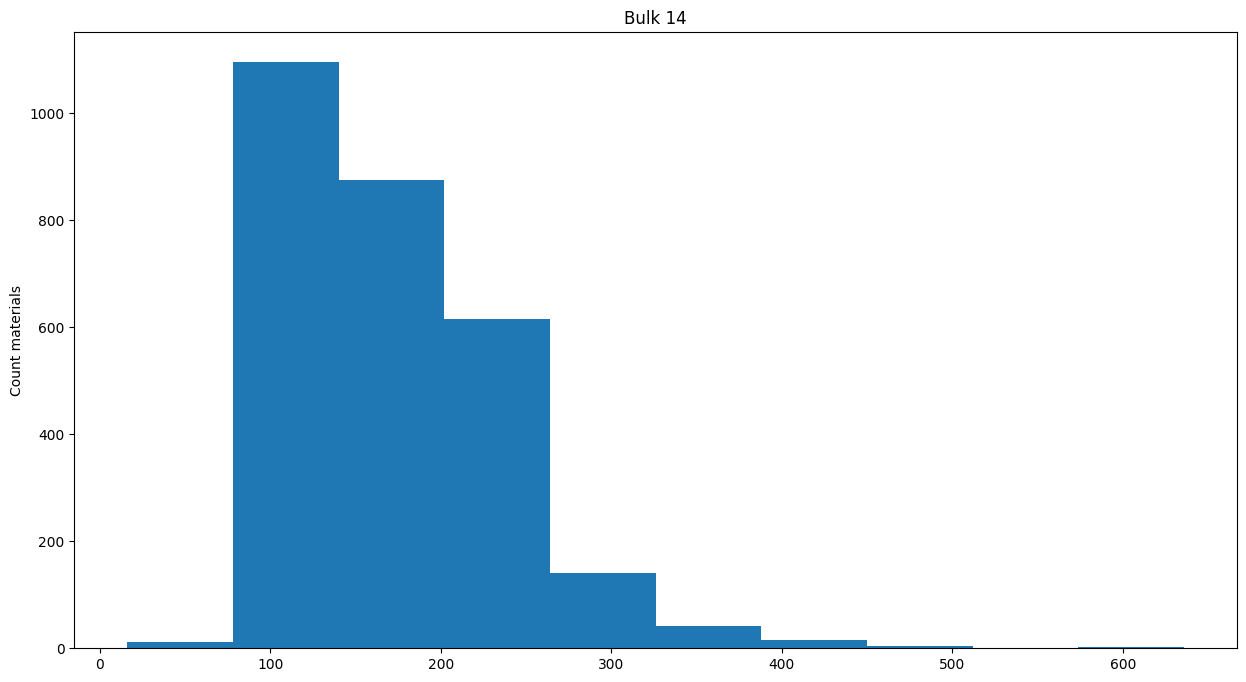

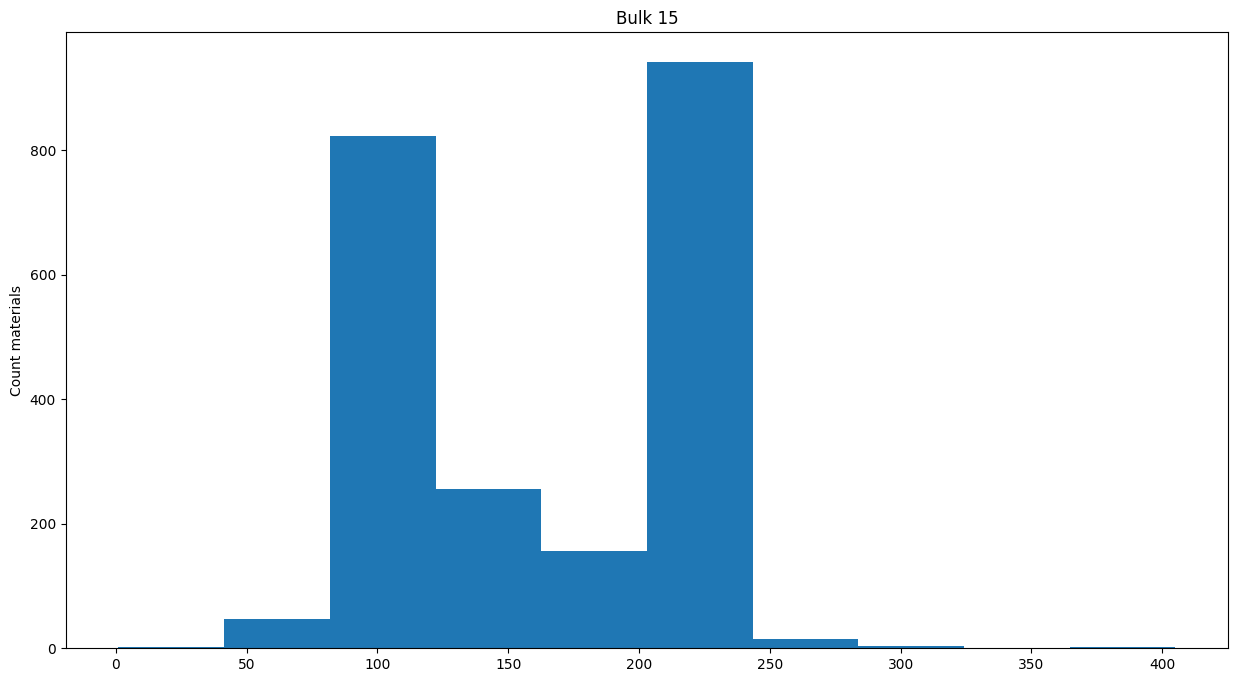

In [295]:
for i in data_bulk.loc[:,'Bulk 1':'Bulk 15'].columns:
    plt.figure(figsize=(15,8))
    plt.title(f'{i}')
    plt.ylabel("Count materials")
    plt.hist(data_bulk[f'{i}'])
    plt.show()

В принципе никаких аонмалий нет

## data_bulk_time

In [296]:
query = f'''
SELECT *
FROM steel.data_bulk_time
'''
data_bulk_time = pd.read_sql_query(sql=text(query), con = engine.connect())

In [297]:
get_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1812,1873,None,None,22:13:14,None,None,None,None,None,None,None,None,21:39:55,None,21:39:55,21:39:55
131,144,None,None,None,None,None,None,None,None,None,None,None,17:58:12,None,17:58:12,17:58:12
2949,3058,None,None,None,08:59:58,None,None,None,None,None,None,None,08:45:14,None,08:45:14,08:45:14
1996,2066,None,None,None,01:58:01,01:58:01,None,None,None,None,None,None,01:50:17,None,01:50:17,01:50:17
1788,1848,None,None,None,01:03:20,None,None,None,None,None,None,None,00:58:08,None,00:58:08,00:58:08


Дмаю стоит объеденить две таблицы, но во первых нужно переименовать колонки.

In [298]:
data_bulk_time.columns = ['key', 'TBulk 1', 'TBulk 2', 'TBulk 3', 'TBulk 4', 'TBulk 5', 'TBulk 6',
       'TBulk 7', 'TBulk 8', 'TBulk 9', 'TBulk 10', 'TBulk 11', 'TBulk 12',
       'TBulk 13', 'TBulk 14', 'TBulk 15']

In [299]:
data_bulk_time

,key,TBulk 1,TBulk 2,TBulk 3,TBulk 4,TBulk 5,TBulk 6,TBulk 7,TBulk 8,TBulk 9,TBulk 10,TBulk 11,TBulk 12,TBulk 13,TBulk 14,TBulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,None,None,22:51:28,None,None,None,None,None,None,None,None,22:46:52,None,22:46:52,22:46:52
3125,3238,None,None,23:39:11,None,None,None,None,None,None,None,None,23:33:09,None,23:33:09,23:33:09
3126,3239,None,None,None,None,None,01:51:58,None,None,None,None,None,01:39:41,None,01:33:25,01:33:25
3127,3240,None,None,None,None,None,03:12:40,None,None,None,None,None,None,None,02:41:27,02:41:27


In [300]:
data_bulk = pd.merge(left=data_bulk,
                    right=data_bulk_time,
                    on='key')

In [301]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       3129 non-null   int64  
 1   Bulk 1    252 non-null    float64
 2   Bulk 2    22 non-null     float64
 3   Bulk 3    1298 non-null   float64
 4   Bulk 4    1014 non-null   float64
 5   Bulk 5    77 non-null     float64
 6   Bulk 6    576 non-null    float64
 7   Bulk 7    25 non-null     float64
 8   Bulk 8    1 non-null      float64
 9   Bulk 9    19 non-null     float64
 10  Bulk 10   176 non-null    float64
 11  Bulk 11   177 non-null    float64
 12  Bulk 12   2450 non-null   float64
 13  Bulk 13   18 non-null     float64
 14  Bulk 14   2806 non-null   float64
 15  Bulk 15   2248 non-null   float64
 16  Count     3129 non-null   int64  
 17  TBulk 1   252 non-null    object 
 18  TBulk 2   22 non-null     object 
 19  TBulk 3   1298 non-null   object 
 20  TBulk 4   1014 non-null   obje

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,TBulk 6,TBulk 7,TBulk 8,TBulk 9,TBulk 10,TBulk 11,TBulk 12,TBulk 13,TBulk 14,TBulk 15
1869,1932,NaN,NaN,81.0,NaN,NaN,155.0,NaN,NaN,NaN,...,13:10:20,None,None,None,None,None,12:51:33,None,12:51:33,12:51:33
2242,2323,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,19:14:54,None,18:58:14,None,18:58:14,18:58:14
1601,1661,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,17:20:50,None,17:20:50,17:20:50
2475,2567,48.0,254.0,NaN,NaN,NaN,NaN,462.0,NaN,NaN,...,None,14:45:03,None,None,None,None,None,None,None,None
1143,1191,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


Как видно, некоторые материалы добавляются одновременно, и это можно считать одной итерацией.

По этому нужно производить подсчет не только по количеству различных материалов, но и по времени их добавления.

Для этого нужно рассмотреть последующие таблицы материалов.

## data_gas

In [302]:
query = f'''
SELECT *
FROM steel.data_gas
'''
data_gas = pd.read_sql_query(sql=text(query), con = engine.connect())

In [303]:
get_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
1183,1186,8.407657
3080,3083,8.029594
355,358,19.647367
1140,1143,13.094869
1370,1373,31.949978


Ну тут все просто, просто партия и количество потраченого на нее газа, думаю количество газа на прямую зависит от объема поданых материалов, но что-бы это проверить нужно разбратсья с объемаами мамтериалов и их добавлением в сталь.

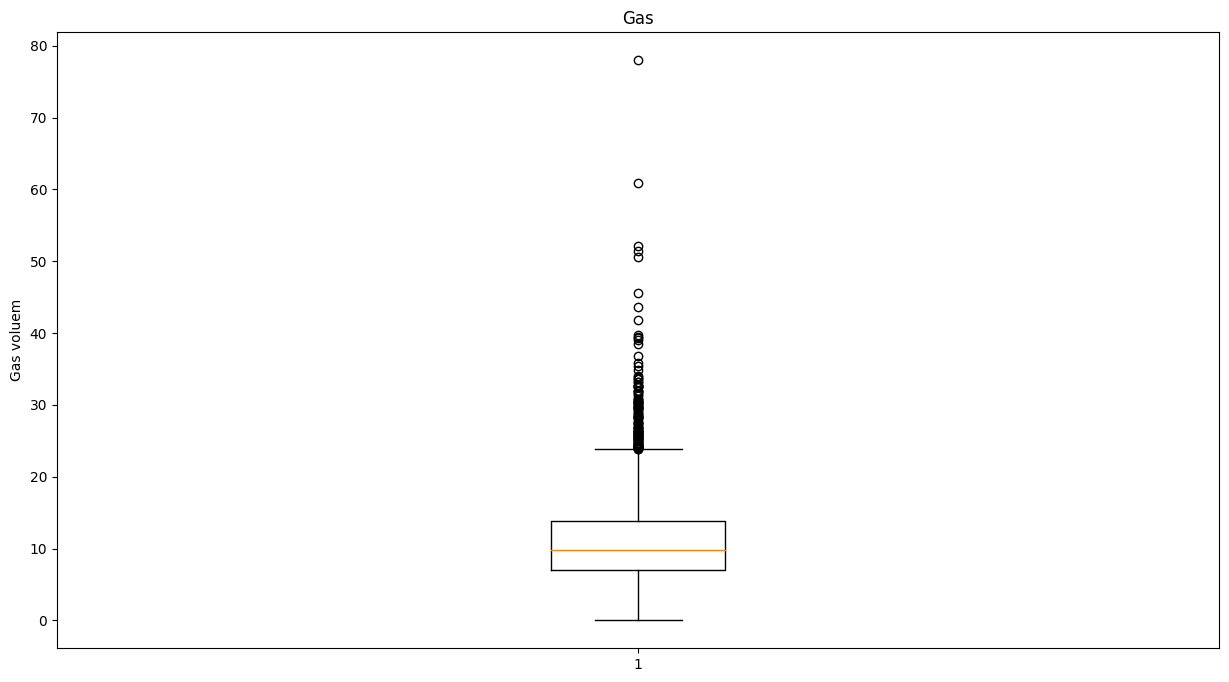

In [304]:
plt.figure(figsize=(15,8))
plt.title('Gas')
plt.ylabel("Gas voluem")
plt.boxplot(data_gas['gas'])
plt.show()

Распределение очень похоже на распределние мощности, видимо это напрямую зависит от объема сырья

## data_temp

In [305]:
query = f'''
SELECT *
FROM steel.data_temp
'''
data_temp = pd.read_sql_query(sql=text(query), con = engine.connect())

In [306]:
get_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,MesaureTime,Temperature
8049,1640,00:53:16,1592.0
13581,2763,15:18:33,NaN
10268,2080,12:43:36,1554.0
2845,550,20:27:24,1604.0
2300,436,12:28:10,1575.0


Это наша целевая таблица данных, тут температура, ее вермя измерения и номер партии, присоединять ее бует после материалов.

Заказчик сказал, что температура ниже 1500 градусов - это аномалия, нужно проверить есть ли такие значения.

In [307]:
data_temp.loc[data_temp['Temperature'] < 1500]

,key,MesaureTime,Temperature
4350,867,14:21:00,1191.0
5978,1214,05:32:00,1208.0
7958,1619,11:03:54,1218.0
8913,1818,00:30:49,1383.0
8914,1818,00:31:40,1383.0
10127,2052,14:51:40,1227.0
12564,2561,07:34:15,1204.0


Есть пара аномальных значений, нужно посмотреть какие это замеры, если промежуточные то можно просто удалить.

In [308]:
for i in data_temp.loc[data_temp['Temperature'] < 1500, 'key'].unique():
    display(data_temp.loc[data_temp['key'] == i])

,key,MesaureTime,Temperature
4350,867,14:21:00,1191.0
4351,867,14:29:35,1575.0
4352,867,14:30:29,1576.0
4353,867,14:43:10,1571.0
4354,867,14:52:54,1600.0
4355,867,14:57:17,1599.0


,key,MesaureTime,Temperature
5978,1214,05:32:00,1208.0
5979,1214,05:49:01,1608.0
5980,1214,05:51:28,1608.0
5981,1214,05:51:38,1608.0
5982,1214,05:52:41,1608.0
5983,1214,05:53:03,1608.0
5984,1214,05:53:13,1608.0
5985,1214,05:54:48,1604.0
5986,1214,05:57:21,1604.0
5987,1214,06:00:25,1604.0


,key,MesaureTime,Temperature
7958,1619,11:03:54,1218.0
7959,1619,11:04:39,1623.0
7960,1619,11:10:01,1611.0
7961,1619,11:16:03,1603.0
7962,1619,11:21:54,1590.0


,key,MesaureTime,Temperature
8907,1818,00:00:14,1627.0
8908,1818,00:13:02,1650.0
8909,1818,00:25:28,1650.0
8910,1818,00:26:03,1650.0
8911,1818,00:26:42,1650.0
8912,1818,00:27:23,1663.0
8913,1818,00:30:49,1383.0
8914,1818,00:31:40,1383.0
8915,1818,00:32:55,1680.0
8916,1818,00:36:11,1667.0


,key,MesaureTime,Temperature
10127,2052,14:51:40,1227.0
10128,2052,14:52:21,1592.0
10129,2052,15:06:31,1590.0
10130,2052,15:15:24,1591.0
10131,2052,15:24:06,1592.0


,key,MesaureTime,Temperature
12564,2561,07:34:15,1204.0
12565,2561,07:35:02,NaN
12566,2561,07:35:38,NaN
12567,2561,07:49:07,NaN
12568,2561,07:54:21,NaN
12569,2561,07:56:57,NaN


Все значения встречаются в начале, кроме ключа 1818, значит эти партии нужно удалить.

In [309]:
for i in data_temp.loc[data_temp['Temperature'] < 1500, 'key'].unique():
    data_temp = data_temp.loc[data_temp['key'] != i]

In [310]:
data_temp.loc[data_temp['Temperature'] < 1500, 'key'].unique()

array([], dtype=int64)

## data_wire

In [311]:
query = f'''
SELECT *
FROM steel.data_wire
'''
data_wire = pd.read_sql_query(sql=text(query), con = engine.connect())

In [312]:
get_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1376,1448,225.950394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2788,2941,96.358081,35.287201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,855,91.213200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,379,166.280410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,989,127.155593,85.201996,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Первое что бросается в глаза, это количество столбцов, в описании их было 15, тут всего 9, думаю это просто ошибка в описании проекта. 

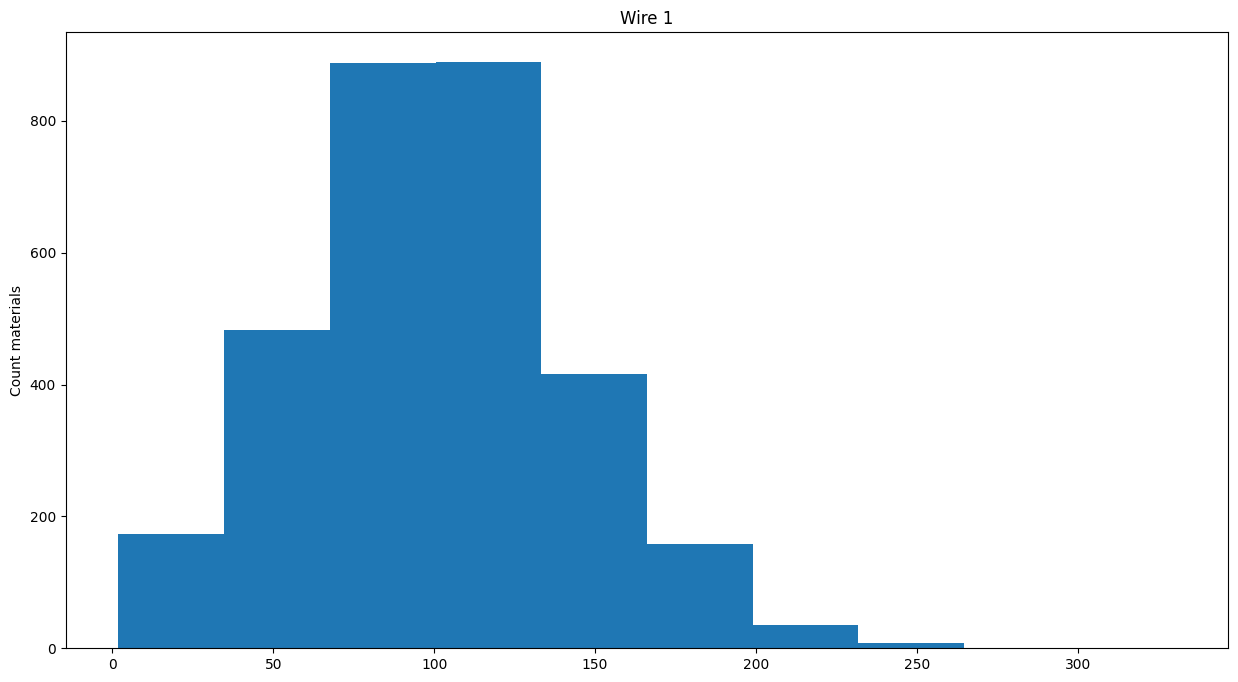

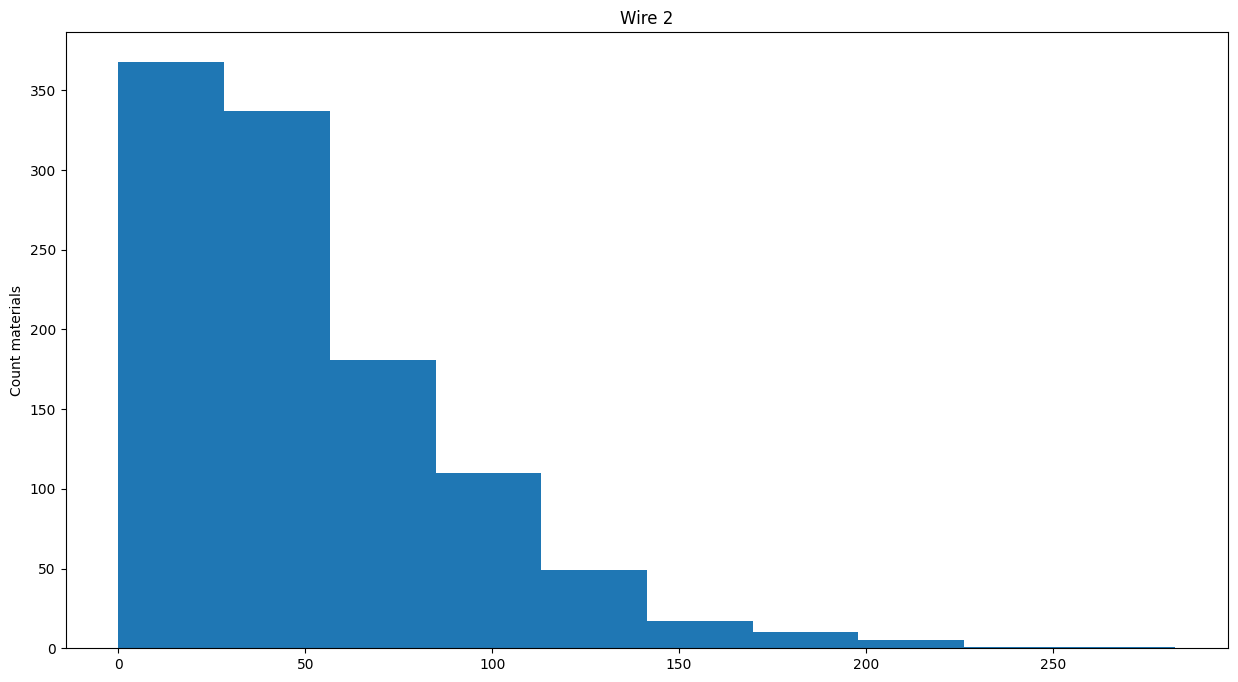

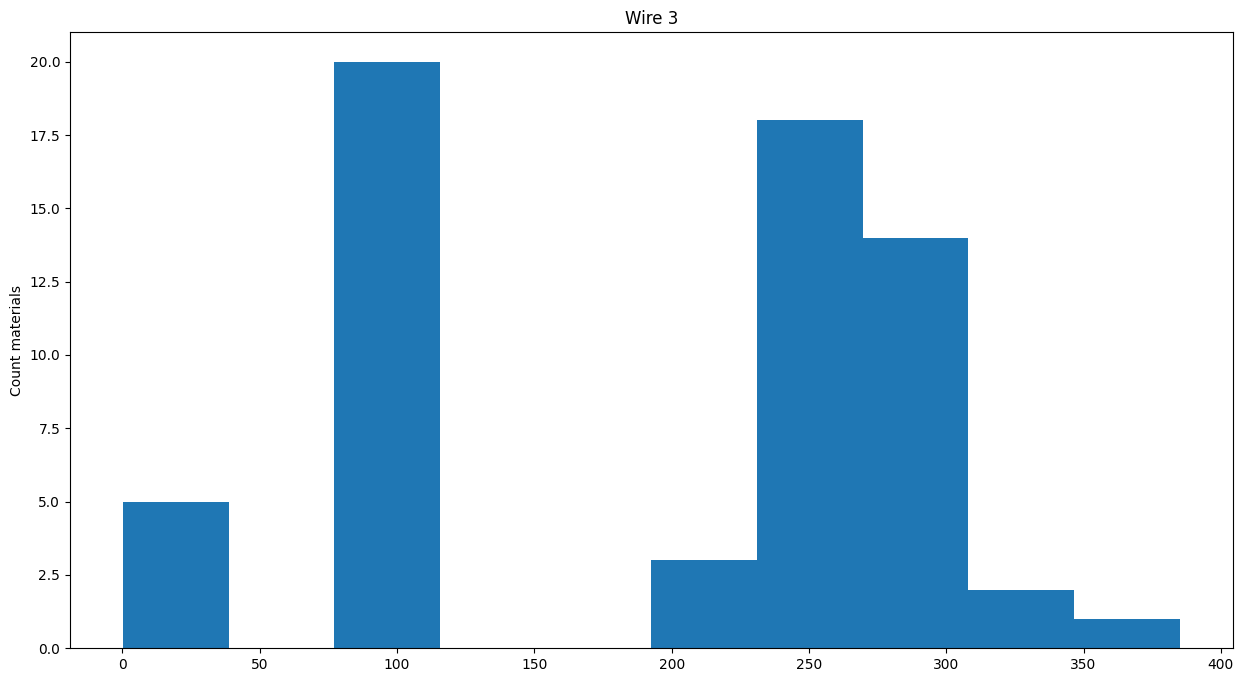

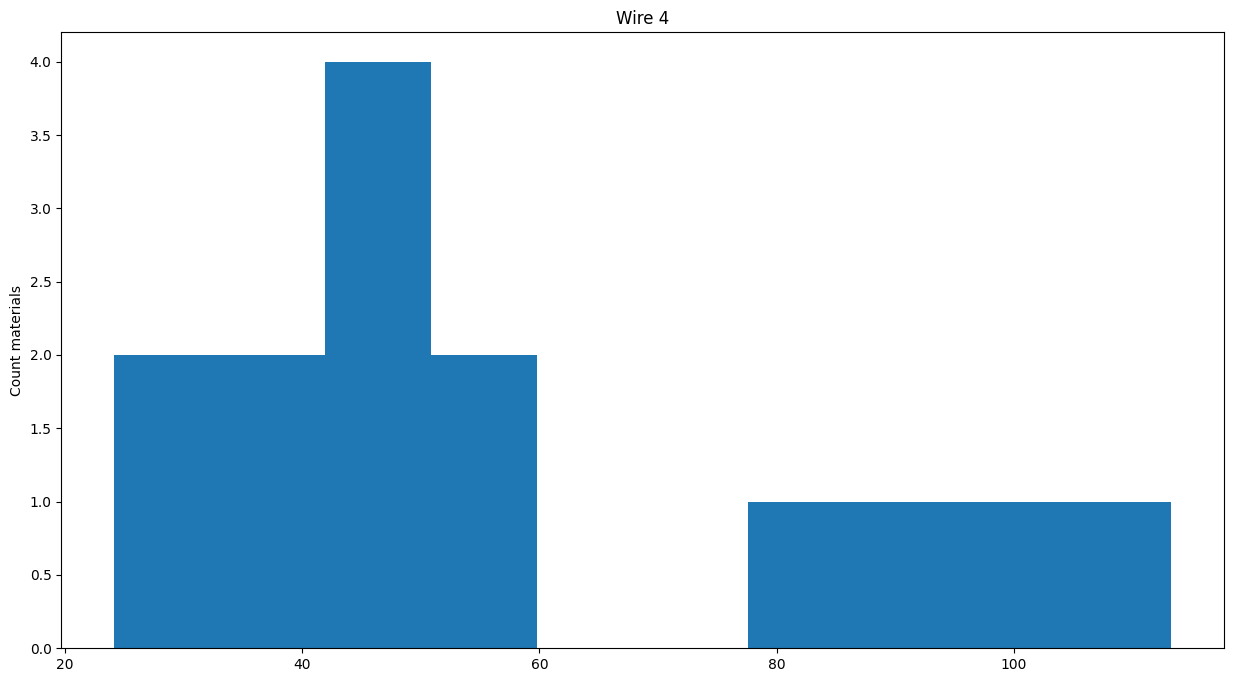

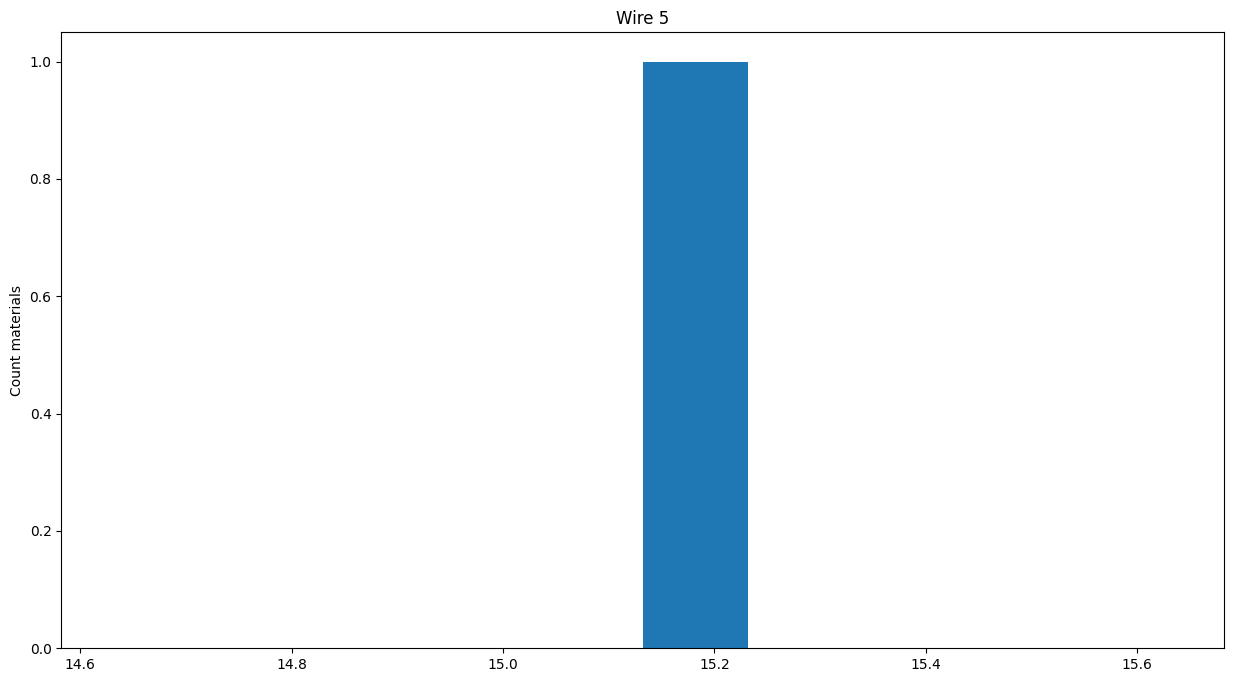

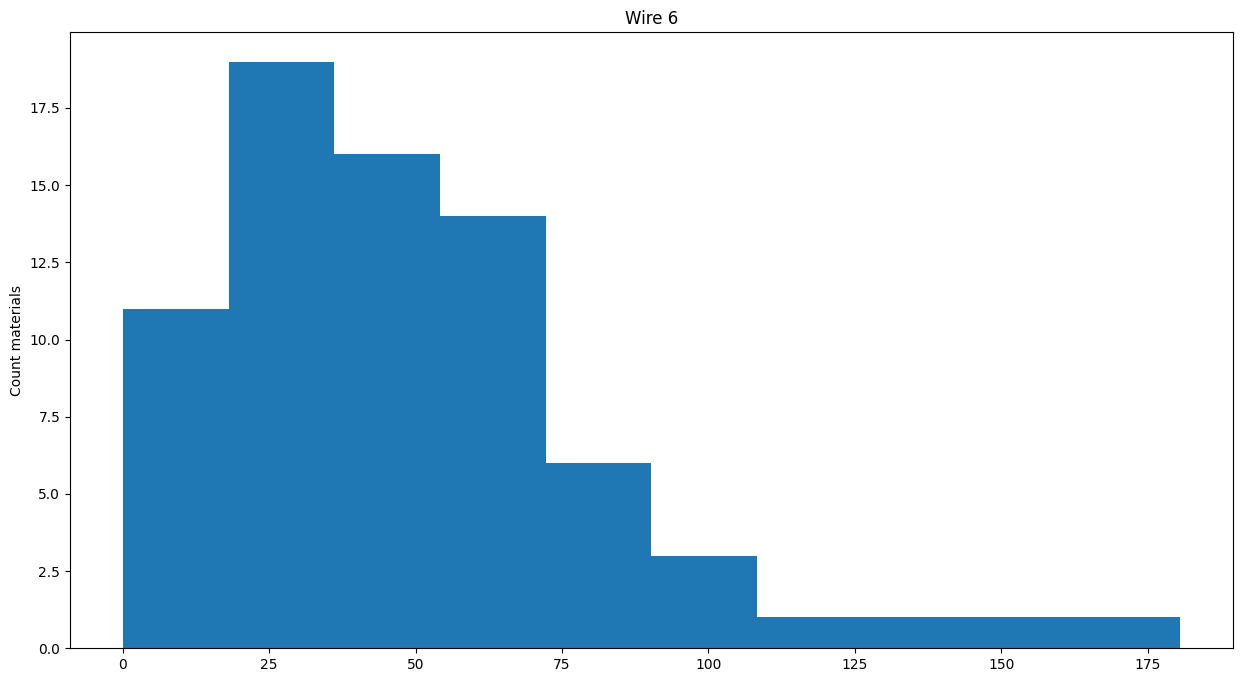

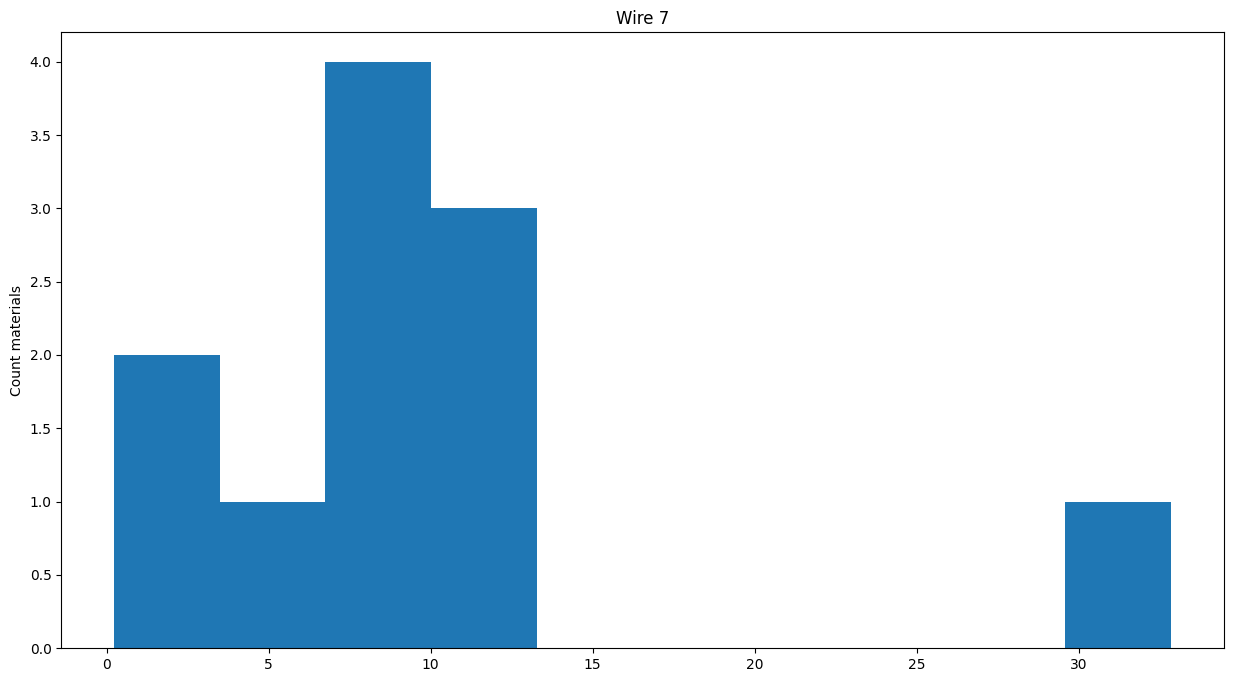

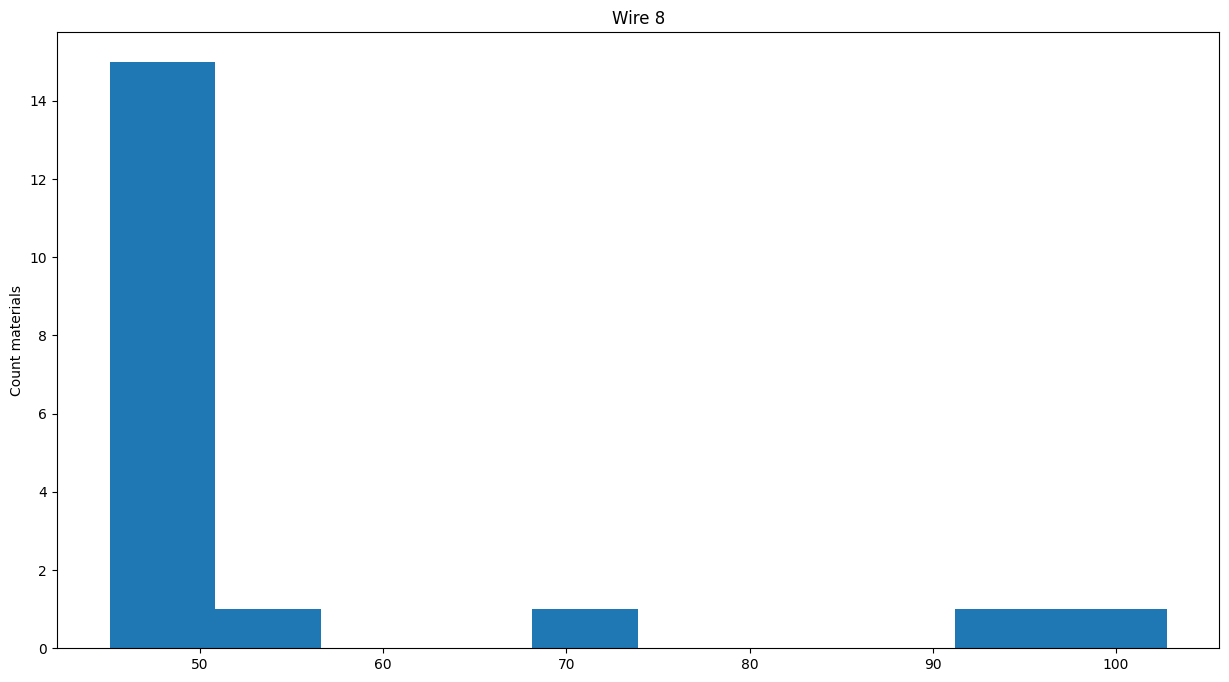

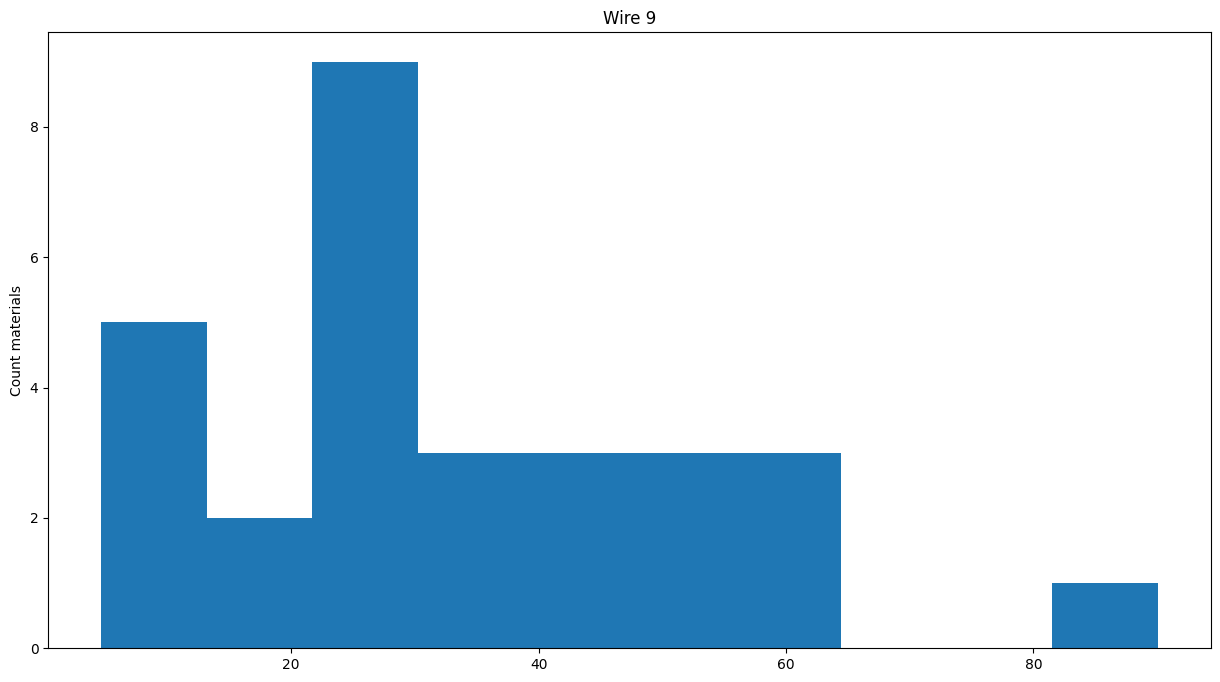

In [313]:
for i in data_wire.loc[:,'Wire 1':'Wire 9'].columns:
    plt.figure(figsize=(15,8))
    plt.title(f'{i}')
    plt.ylabel("Count materials")
    plt.hist(data_wire[f'{i}'])
    plt.show()

На первый взгляд все хорошо.

## data_wire_time

In [314]:
query = f'''
SELECT *
FROM steel.data_wire_time
'''
data_wire_time = pd.read_sql_query(sql=text(query), con = engine.connect())

In [315]:
get_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1663,1749,09:06:25,09:09:27,None,None,None,None,None,None,None
2809,2962,22:53:40,None,None,None,None,None,None,None,None
1959,2056,17:44:03,18:02:05,None,None,None,None,None,None,None
869,922,08:48:42,None,None,None,None,None,None,None,None
2530,2663,02:14:41,02:18:05,None,None,None,None,None,None,None


Стоит поступить тут как и с сыпучими материалами, объединяем таблицы.

In [316]:
data_wire_time.columns = ['key', 'TWire 1', 'TWire 2', 'TWire 3', 'TWire 4', 'TWire 5', 'TWire 6',
       'TWire 7', 'TWire 8', 'TWire 9']

In [317]:
data_wire_time

,key,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3076,3237,22:50:20,None,None,None,None,None,None,None,None
3077,3238,23:38:24,None,None,None,None,None,None,None,None
3078,3239,01:50:43,None,None,None,None,None,None,None,None
3079,3240,03:12:02,None,None,None,None,None,None,None,None


In [318]:
data_wire = pd.merge(left=data_wire,
                    right=data_wire_time,
                    on='key')

In [319]:
get_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3081 non-null   int64  
 1   Wire 1   3055 non-null   float64
 2   Wire 2   1079 non-null   float64
 3   Wire 3   63 non-null     float64
 4   Wire 4   14 non-null     float64
 5   Wire 5   1 non-null      float64
 6   Wire 6   73 non-null     float64
 7   Wire 7   11 non-null     float64
 8   Wire 8   19 non-null     float64
 9   Wire 9   29 non-null     float64
 10  TWire 1  3055 non-null   object 
 11  TWire 2  1079 non-null   object 
 12  TWire 3  63 non-null     object 
 13  TWire 4  14 non-null     object 
 14  TWire 5  1 non-null      object 
 15  TWire 6  73 non-null     object 
 16  TWire 7  11 non-null     object 
 17  TWire 8  19 non-null     object 
 18  TWire 9  29 non-null     object 
dtypes: float64(9), int64(1), object(9)
memory usage: 481.4+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
1384,1456,184.392006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21:53:26,None,None,None,None,None,None,None,None
2124,2232,116.145119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16:29:56,None,None,None,None,None,None,None,None
2107,2209,85.088639,136.293045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22:17:22,22:19:19,None,None,None,None,None,None,None
1084,1151,133.192795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:44:41,None,None,None,None,None,None,None,None
2598,2732,119.202720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:42:23,None,None,None,None,None,None,None,None


## Работа с добавками.

Думаю для лучшего понимания, когда что добавляется и как много, стоит обеденить таблици с сыпучими материалами и проволочными.

In [320]:
data_materials = pd.merge(left=data_bulk,
                            right=data_wire,
                            on='key',
                            how='outer')

In [321]:
get_info(data_materials)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 50 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       3185 non-null   int64  
 1   Bulk 1    252 non-null    float64
 2   Bulk 2    22 non-null     float64
 3   Bulk 3    1298 non-null   float64
 4   Bulk 4    1014 non-null   float64
 5   Bulk 5    77 non-null     float64
 6   Bulk 6    576 non-null    float64
 7   Bulk 7    25 non-null     float64
 8   Bulk 8    1 non-null      float64
 9   Bulk 9    19 non-null     float64
 10  Bulk 10   176 non-null    float64
 11  Bulk 11   177 non-null    float64
 12  Bulk 12   2450 non-null   float64
 13  Bulk 13   18 non-null     float64
 14  Bulk 14   2806 non-null   float64
 15  Bulk 15   2248 non-null   float64
 16  Count     3129 non-null   float64
 17  TBulk 1   252 non-null    object 
 18  TBulk 2   22 non-null     object 
 19  TBulk 3   1298 non-null   object 
 20  TBulk 4   1014 non-null   obje

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Wire 9,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
198,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,04:51:57,04:52:56,None,None,None,None,None,None,None
2753,2856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,00:44:42,None,None,None,None,None,None,None,None
3008,3117,NaN,NaN,52.0,NaN,86.0,108.0,NaN,NaN,NaN,...,NaN,02:09:44,02:11:48,02:11:18,None,None,None,None,None,None
460,486,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12:39:45,None,None,None,None,None,None,None,None
1930,1996,NaN,NaN,107.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15:11:14,None,None,None,None,None,None,None,None


Теперь нужно грамотно посчитать сколько раз добавляли материалы.

In [322]:
data_materials.loc[:,['TBulk 1', 'TBulk 2', 'TBulk 3', 'TBulk 4', 'TBulk 5', 'TBulk 6',
       'TBulk 7', 'TBulk 8', 'TBulk 9', 'TBulk 10', 'TBulk 11', 'TBulk 12',
       'TBulk 13', 'TBulk 14', 'TBulk 15', 'TWire 1',
       'TWire 2', 'TWire 3', 'TWire 4', 'TWire 5', 'TWire 6', 'TWire 7',
       'TWire 8', 'TWire 9']].head(1).transpose()[0].dropna().unique()


array([datetime.time(11, 21, 30), datetime.time(11, 3, 52),
       datetime.time(11, 11, 41)], dtype=object)

In [323]:
def get_iter(df):
    return len(df.transpose().dropna().unique())

In [324]:
data_materials['Count'] = data_materials.loc[:,['TBulk 1', 'TBulk 2', 'TBulk 3', 'TBulk 4', 'TBulk 5', 'TBulk 6',
       'TBulk 7', 'TBulk 8', 'TBulk 9', 'TBulk 10', 'TBulk 11', 'TBulk 12',
       'TBulk 13', 'TBulk 14', 'TBulk 15', 'TWire 1',
       'TWire 2', 'TWire 3', 'TWire 4', 'TWire 5', 'TWire 6', 'TWire 7',
       'TWire 8', 'TWire 9']].apply(get_iter, axis=1)

In [325]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data_materials.loc[1:2,:])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Count,TBulk 1,TBulk 2,TBulk 3,TBulk 4,TBulk 5,TBulk 6,TBulk 7,TBulk 8,TBulk 9,TBulk 10,TBulk 11,TBulk 12,TBulk 13,TBulk 14,TBulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,3,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:46:10,None,None,None,None,None,None,None,None
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:13:47,None,None,None,None,None,None,None,None


In [326]:
data_materials[['key','Count']]

,key,Count
0,1,3
1,2,3
2,3,3
3,4,3
4,5,4
...,...,...
3180,3018,2
3181,3026,2
3182,3047,1
3183,3182,2


In [327]:
data_arc.loc[data_arc['key'] == 2]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
5,2,11:34:14,11:36:31,0.438063,0.283043,137,0.521549,0.646124
6,2,11:38:50,11:44:28,1.296415,0.892914,338,1.574162,0.688756
7,2,11:46:19,11:48:25,0.490377,0.305281,126,0.577638,0.622544
8,2,11:49:48,11:53:18,0.827743,0.516874,210,0.975867,0.624438


In [328]:
data_temp.loc[data_temp['key'] == 2]

,key,MesaureTime,Temperature
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0
10,2,11:59:12,1602.0


In [329]:
data_gas.loc[data_gas['key'] == 2]

,key,gas
1,2,12.555561


In [330]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data_materials.loc[data_materials['key'] == 2])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Count,TBulk 1,TBulk 2,TBulk 3,TBulk 4,TBulk 5,TBulk 6,TBulk 7,TBulk 8,TBulk 9,TBulk 10,TBulk 11,TBulk 12,TBulk 13,TBulk 14,TBulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,3,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:46:10,None,None,None,None,None,None,None,None


In [331]:
table

,Power,key
0,5,1
1,4,2
2,5,3
3,4,4
4,4,5
...,...,...
3208,5,3237
3209,3,3238
3210,8,3239
3211,5,3240


In [332]:
data_materials['Count'] += 1

In [333]:
chek = pd.merge(left=data_materials[['key','Count']],
                right=table,
                on= 'key')

In [334]:
sum(chek['Power'] == chek['Count'])

862

Как видно, не получается получить одинаковое количество итераций и добавок, по этому будем просто использовать объединеное значение.

## Подготовка таблиц к объеднению

### data_arc

In [335]:
data_arc = data_arc.groupby(['key']).sum()

In [336]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    3213 non-null   float64
 1   ReactivePower  3213 non-null   float64
 2   TimeHeat       3213 non-null   int64  
 3   Power          3213 non-null   float64
 4   RatioPower     3213 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.6 KB


None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
key,,,,,
2216,3.017946,2.285015,786,3.785894,3.800354
1945,1.651375,0.999855,444,1.930501,2.418450
1361,2.626795,1.987343,700,3.295233,3.700416
979,1.370791,1.025834,377,1.712232,1.497192
1446,2.886188,2.021666,759,3.525769,4.232398


Нужно заново создать столбец `RatioPower`, с правильными значениями

In [337]:
data_arc['RatioPower'] = data_arc['ReactivePower']/data_arc['ActivePower']

In [338]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    3213 non-null   float64
 1   ReactivePower  3213 non-null   float64
 2   TimeHeat       3213 non-null   int64  
 3   Power          3213 non-null   float64
 4   RatioPower     3213 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.6 KB


None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower
key,,,,,
1630,1.927251,1.312845,466,2.332339,0.681201
551,2.805547,2.235299,775,3.588183,0.796743
712,2.426364,1.736356,601,2.983861,0.715620
2484,0.815230,0.568836,246,0.994560,0.697761
193,4.098016,3.027555,1040,5.099876,0.738786


Прекрасно, можно идти дальше.

### data_bulk

По скольку пропуски оначают что материал не подавался, то заполним их просто нулями.

In [339]:
data_bulk = data_bulk.fillna(0)

In [340]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       3129 non-null   int64  
 1   Bulk 1    3129 non-null   float64
 2   Bulk 2    3129 non-null   float64
 3   Bulk 3    3129 non-null   float64
 4   Bulk 4    3129 non-null   float64
 5   Bulk 5    3129 non-null   float64
 6   Bulk 6    3129 non-null   float64
 7   Bulk 7    3129 non-null   float64
 8   Bulk 8    3129 non-null   float64
 9   Bulk 9    3129 non-null   float64
 10  Bulk 10   3129 non-null   float64
 11  Bulk 11   3129 non-null   float64
 12  Bulk 12   3129 non-null   float64
 13  Bulk 13   3129 non-null   float64
 14  Bulk 14   3129 non-null   float64
 15  Bulk 15   3129 non-null   float64
 16  Count     3129 non-null   int64  
 17  TBulk 1   3129 non-null   object 
 18  TBulk 2   3129 non-null   object 
 19  TBulk 3   3129 non-null   object 
 20  TBulk 4   3129 non-null   obje

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,TBulk 6,TBulk 7,TBulk 8,TBulk 9,TBulk 10,TBulk 11,TBulk 12,TBulk 13,TBulk 14,TBulk 15
1073,1120,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,02:34:38,0,02:34:38,02:34:38
767,801,0.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,01:22:08,0,01:22:08,04:32:02
2062,2134,0.0,0.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,14:14:38,0,14:14:38,14:14:38
635,666,0.0,0.0,270.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,00:41:41,0,00:41:41,00:41:41
1327,1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,05:40:40,0,0,0


Так же нам не нужно время подачи, по этому уберем эти столбцы

In [341]:
data_bulk = data_bulk.loc[:,'key':'Bulk 15']

### data_wire

In [342]:
data_wire = data_wire.fillna(0)

In [343]:
get_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3081 non-null   int64  
 1   Wire 1   3081 non-null   float64
 2   Wire 2   3081 non-null   float64
 3   Wire 3   3081 non-null   float64
 4   Wire 4   3081 non-null   float64
 5   Wire 5   3081 non-null   float64
 6   Wire 6   3081 non-null   float64
 7   Wire 7   3081 non-null   float64
 8   Wire 8   3081 non-null   float64
 9   Wire 9   3081 non-null   float64
 10  TWire 1  3081 non-null   object 
 11  TWire 2  3081 non-null   object 
 12  TWire 3  3081 non-null   object 
 13  TWire 4  3081 non-null   object 
 14  TWire 5  3081 non-null   object 
 15  TWire 6  3081 non-null   object 
 16  TWire 7  3081 non-null   object 
 17  TWire 8  3081 non-null   object 
 18  TWire 9  3081 non-null   object 
dtypes: float64(9), int64(1), object(9)
memory usage: 481.4+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,TWire 1,TWire 2,TWire 3,TWire 4,TWire 5,TWire 6,TWire 7,TWire 8,TWire 9
2828,2981,148.206238,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14:59:22,0,0,0,0,0,0,0,0
1497,1576,47.174400,65.085281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03:35:09,03:36:38,0,0,0,0,0,0,0
1494,1573,120.229210,110.295120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01:03:50,01:05:52,0,0,0,0,0,0,0
2060,2158,79.017128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07:58:40,0,0,0,0,0,0,0,0
732,780,84.520805,185.122086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,08:42:00,08:45:17,0,0,0,0,0,0,0


Так же нам не нужно время подачи материала.

In [344]:
data_wire = data_wire.loc[:,'key':'Wire 9']

### data_temp 

Нам необходимо научить модель предсказывать финальную температуру, по этому для каждого ключа получим начальную тепературу, будум ее использовать как фичу, и финальную тепературу, как целевой призгак.

In [345]:
data_temp = data_temp.sort_values(by=['key', 'MesaureTime'])

In [346]:
data_temp.head(10)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


Поскольку у нас есть измерения где могут отсутствовать значения их нужно исключить.

In [458]:
data_temp = data_temp.fillna(0)

In [459]:
data_temp1 = data_temp.groupby(['key']).agg({'Temperature':['first','last']})

In [460]:
data_temp1.columns = ['Temperature', 'Target']

In [461]:
data_temp1['key'] = data_temp1.index

In [462]:
data_temp1 = data_temp1.reset_index(drop=True)

Теперь если у нас встречается нуевое значение, зачит это пропуск и эти колонки можно удалить.

In [463]:
data_temp1 = data_temp1.loc[(data_temp1['Temperature'] != 0) & (data_temp1['Target'] != 0)]

In [464]:
get_info(data_temp1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2472 entries, 0 to 2471
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2472 non-null   float64
 1   Target       2472 non-null   float64
 2   key          2472 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


None

,Temperature,Target,key
1896,1574.0,1586.0,1915
381,1640.0,1591.0,386
180,1581.0,1595.0,183
1569,1566.0,1588.0,1586
2158,1560.0,1587.0,2180


### Объединение.

In [465]:
df = pd.merge(left=data_arc,
            right=data_bulk,
            on='key')

In [466]:
df = pd.merge(left=df,
                right=data_gas,
                on='key')

In [467]:
df = pd.merge(left=df,
                right=data_wire,
                on='key')

In [468]:
df = pd.merge(left=df,
            right=data_temp1,
            on='key')

In [469]:
df = df.drop(['key'],axis=1)

In [470]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    2324 non-null   float64
 1   ReactivePower  2324 non-null   float64
 2   TimeHeat       2324 non-null   int64  
 3   Power          2324 non-null   float64
 4   RatioPower     2324 non-null   float64
 5   Bulk 1         2324 non-null   float64
 6   Bulk 2         2324 non-null   float64
 7   Bulk 3         2324 non-null   float64
 8   Bulk 4         2324 non-null   float64
 9   Bulk 5         2324 non-null   float64
 10  Bulk 6         2324 non-null   float64
 11  Bulk 7         2324 non-null   float64
 12  Bulk 8         2324 non-null   float64
 13  Bulk 9         2324 non-null   float64
 14  Bulk 10        2324 non-null   float64
 15  Bulk 11        2324 non-null   float64
 16  Bulk 12        2324 non-null   float64
 17  Bulk 13        2324 non-null   float64
 18  Bulk 14 

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature,Target
2024,1.445591,1.075015,401,1.804026,0.743651,0.0,0.0,0.0,106.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1636.0,1589.0
407,3.142757,2.206556,744,3.841654,0.702109,0.0,0.0,0.0,0.0,0.0,...,23.012081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1578.0,1599.0
2195,2.757768,1.983244,635,3.397384,0.719149,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1585.0
586,2.817397,2.060155,676,3.492669,0.731226,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1577.0,1596.0
1832,2.602908,1.993592,690,3.279651,0.765910,0.0,0.0,0.0,164.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618.0,1602.0


Таблица готова к последующему обучению модели.

## Подготовка данных к обучению

### Разделение на выборки.

Прежде чем отправлять данные моделе, нужно их разделить и привести к нужному виду.

In [471]:
train, test = train_test_split(df, test_size=.2, random_state=RANDOM_STATE)
train, vall = train_test_split(train, test_size=.25, random_state=RANDOM_STATE)

In [472]:
get_info(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 397 to 280
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    1394 non-null   float64
 1   ReactivePower  1394 non-null   float64
 2   TimeHeat       1394 non-null   int64  
 3   Power          1394 non-null   float64
 4   RatioPower     1394 non-null   float64
 5   Bulk 1         1394 non-null   float64
 6   Bulk 2         1394 non-null   float64
 7   Bulk 3         1394 non-null   float64
 8   Bulk 4         1394 non-null   float64
 9   Bulk 5         1394 non-null   float64
 10  Bulk 6         1394 non-null   float64
 11  Bulk 7         1394 non-null   float64
 12  Bulk 8         1394 non-null   float64
 13  Bulk 9         1394 non-null   float64
 14  Bulk 10        1394 non-null   float64
 15  Bulk 11        1394 non-null   float64
 16  Bulk 12        1394 non-null   float64
 17  Bulk 13        1394 non-null   float64
 18  Bulk 14

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature,Target
2049,3.053793,2.254685,696,3.799666,0.738323,0.0,0.0,0.0,151.0,0.0,...,16.10544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1559.0,1589.0
819,3.732320,2.575058,846,4.534918,0.689935,0.0,0.0,0.0,86.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1603.0,1621.0
1363,3.173506,2.324508,896,3.935888,0.732473,0.0,0.0,0.0,84.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1601.0
915,1.938129,1.566473,607,2.494138,0.808240,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1586.0
569,5.014386,3.521438,1205,6.129347,0.702267,0.0,0.0,0.0,117.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1542.0,1589.0


In [473]:
get_info(vall)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 1340 to 2027
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    465 non-null    float64
 1   ReactivePower  465 non-null    float64
 2   TimeHeat       465 non-null    int64  
 3   Power          465 non-null    float64
 4   RatioPower     465 non-null    float64
 5   Bulk 1         465 non-null    float64
 6   Bulk 2         465 non-null    float64
 7   Bulk 3         465 non-null    float64
 8   Bulk 4         465 non-null    float64
 9   Bulk 5         465 non-null    float64
 10  Bulk 6         465 non-null    float64
 11  Bulk 7         465 non-null    float64
 12  Bulk 8         465 non-null    float64
 13  Bulk 9         465 non-null    float64
 14  Bulk 10        465 non-null    float64
 15  Bulk 11        465 non-null    float64
 16  Bulk 12        465 non-null    float64
 17  Bulk 13        465 non-null    float64
 18  Bulk 1

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature,Target
1887,3.624155,2.690061,1078,4.515354,0.742259,0.0,0.0,0.0,0.0,0.0,...,100.101036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1551.0,1575.0
2123,2.728462,2.064907,689,3.423514,0.756803,0.0,0.0,190.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1566.0,1589.0
1864,3.753038,3.691455,1102,5.276812,0.983591,0.0,0.0,107.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1595.0
1729,3.649109,2.712231,945,4.546717,0.743259,0.0,0.0,231.0,0.0,0.0,...,9.017840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1597.0,1589.0
1037,2.663703,1.940802,635,3.300659,0.728610,0.0,0.0,128.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1599.0,1595.0


In [474]:
get_info(test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 679 to 1834
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    465 non-null    float64
 1   ReactivePower  465 non-null    float64
 2   TimeHeat       465 non-null    int64  
 3   Power          465 non-null    float64
 4   RatioPower     465 non-null    float64
 5   Bulk 1         465 non-null    float64
 6   Bulk 2         465 non-null    float64
 7   Bulk 3         465 non-null    float64
 8   Bulk 4         465 non-null    float64
 9   Bulk 5         465 non-null    float64
 10  Bulk 6         465 non-null    float64
 11  Bulk 7         465 non-null    float64
 12  Bulk 8         465 non-null    float64
 13  Bulk 9         465 non-null    float64
 14  Bulk 10        465 non-null    float64
 15  Bulk 11        465 non-null    float64
 16  Bulk 12        465 non-null    float64
 17  Bulk 13        465 non-null    float64
 18  Bulk 14

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature,Target
1282,3.526029,2.454211,786,4.296619,0.696027,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1607.0,1597.0
79,3.144549,2.230562,822,3.858143,0.709343,0.0,0.0,0.0,0.0,0.0,...,18.14176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1578.0,1586.0
1662,1.329005,1.057964,456,1.698716,0.796057,0.0,0.0,41.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1589.0
2263,1.808278,1.530379,490,2.370162,0.846318,0.0,0.0,61.0,0.0,0.0,...,15.14032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1590.0,1593.0
745,5.298894,4.115700,1477,6.711724,0.776709,0.0,0.0,0.0,134.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1582.0,1605.0


Выборки есть, нужно теперь разделит фичи и ответы

In [475]:
X_train = train.drop('Target', axis=1)
Y_train = train['Target']
X_vall = vall.drop('Target', axis=1)
Y_vall = vall['Target']
X_test = test.drop('Target', axis=1)
Y_test = test['Target']

In [476]:
column = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train[column])
pd.options.mode.chained_assignment = None

X_train[column] = scaler.transform(X_train[column])
X_test[column] = scaler.transform(X_test[column])
X_vall[column] = scaler.transform(X_vall[column])

In [477]:
get_info(X_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 397 to 280
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    1394 non-null   float64
 1   ReactivePower  1394 non-null   float64
 2   TimeHeat       1394 non-null   float64
 3   Power          1394 non-null   float64
 4   RatioPower     1394 non-null   float64
 5   Bulk 1         1394 non-null   float64
 6   Bulk 2         1394 non-null   float64
 7   Bulk 3         1394 non-null   float64
 8   Bulk 4         1394 non-null   float64
 9   Bulk 5         1394 non-null   float64
 10  Bulk 6         1394 non-null   float64
 11  Bulk 7         1394 non-null   float64
 12  Bulk 8         1394 non-null   float64
 13  Bulk 9         1394 non-null   float64
 14  Bulk 10        1394 non-null   float64
 15  Bulk 11        1394 non-null   float64
 16  Bulk 12        1394 non-null   float64
 17  Bulk 13        1394 non-null   float64
 18  Bulk 14

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature
126,2.266274,2.079962,1.998712,2.228084,-0.322416,-0.280152,-0.084517,0.323158,-0.654709,-0.124833,...,0.646814,-0.493986,-0.112759,-0.064147,0.0,1.459363,-0.032906,-0.052697,-0.082586,-1.627638
1042,-0.585636,-0.493521,-0.742480,-0.558454,0.378926,-0.280152,-0.084517,1.021233,-0.654709,-0.124833,...,0.011375,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,0.014346
2039,-1.813569,-1.800405,-1.970058,-1.823943,-0.566788,-0.280152,-0.084517,0.165103,-0.654709,-0.124833,...,1.846181,0.650880,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,2.456271
1699,-0.787712,-0.771234,-0.808031,-0.790372,-0.047114,-0.280152,-0.084517,0.415356,-0.654709,-0.124833,...,-0.580729,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,0.266959
871,0.045999,-0.211591,-0.164446,-0.048750,-1.038517,-0.280152,-0.084517,-0.625170,-0.654709,-0.124833,...,0.469397,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,-0.322471


In [478]:
get_info(X_vall)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 1340 to 2027
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    465 non-null    float64
 1   ReactivePower  465 non-null    float64
 2   TimeHeat       465 non-null    float64
 3   Power          465 non-null    float64
 4   RatioPower     465 non-null    float64
 5   Bulk 1         465 non-null    float64
 6   Bulk 2         465 non-null    float64
 7   Bulk 3         465 non-null    float64
 8   Bulk 4         465 non-null    float64
 9   Bulk 5         465 non-null    float64
 10  Bulk 6         465 non-null    float64
 11  Bulk 7         465 non-null    float64
 12  Bulk 8         465 non-null    float64
 13  Bulk 9         465 non-null    float64
 14  Bulk 10        465 non-null    float64
 15  Bulk 11        465 non-null    float64
 16  Bulk 12        465 non-null    float64
 17  Bulk 13        465 non-null    float64
 18  Bulk 1

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature
1972,0.037345,-0.050818,0.377833,0.003891,-0.387943,-0.280152,-0.084517,-0.625170,-0.654709,-0.124833,...,-0.812850,-0.493986,-0.112759,-0.064147,0.0,1.347642,-0.032906,-0.052697,-0.082586,0.814287
1542,0.695825,1.299152,0.881378,0.936025,1.796699,-0.280152,-0.084517,1.692965,-0.654709,-0.124833,...,0.340679,1.164846,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,-1.585536
1539,-1.236701,-1.199533,-1.031497,-1.234415,0.057365,-0.280152,-0.084517,-0.295890,-0.654709,-0.124833,...,-1.065567,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,1.151104
34,-0.050850,-0.412215,-0.322363,-0.179883,-1.508330,-0.280152,-0.084517,2.575437,0.060454,-0.124833,...,0.630796,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,-0.111960
1881,0.782238,0.657772,0.613218,0.737742,-0.365363,-0.280152,-0.084517,-0.625170,1.573937,-0.124833,...,0.197301,-0.039847,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,-1.164514


In [479]:
get_info(X_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 679 to 1834
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ActivePower    465 non-null    float64
 1   ReactivePower  465 non-null    float64
 2   TimeHeat       465 non-null    float64
 3   Power          465 non-null    float64
 4   RatioPower     465 non-null    float64
 5   Bulk 1         465 non-null    float64
 6   Bulk 2         465 non-null    float64
 7   Bulk 3         465 non-null    float64
 8   Bulk 4         465 non-null    float64
 9   Bulk 5         465 non-null    float64
 10  Bulk 6         465 non-null    float64
 11  Bulk 7         465 non-null    float64
 12  Bulk 8         465 non-null    float64
 13  Bulk 9         465 non-null    float64
 14  Bulk 10        465 non-null    float64
 15  Bulk 11        465 non-null    float64
 16  Bulk 12        465 non-null    float64
 17  Bulk 13        465 non-null    float64
 18  Bulk 14

None

,ActivePower,ReactivePower,TimeHeat,Power,RatioPower,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature
1668,-1.354804,-1.348453,-1.311576,-1.364939,-0.264806,-0.280152,-0.084517,-0.625170,0.509509,-0.124833,...,0.310645,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,1.782637
554,-0.047746,-0.051351,-0.069101,-0.049281,-0.068393,-0.280152,-0.084517,1.100260,-0.654709,-0.124833,...,-0.100181,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,1.866841
289,4.555961,5.327204,5.541405,4.883243,1.059984,14.721590,-0.084517,0.705123,0.309929,-0.124833,...,-2.350603,5.163266,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,1.319513
653,-1.353793,-1.360686,-1.219209,-1.367856,-0.398548,-0.280152,-0.084517,-0.625170,1.208040,-0.124833,...,1.550630,-0.493986,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,0.772185
1314,-1.041523,-0.951521,-1.144721,-1.018820,0.461462,3.450011,-0.084517,0.507555,-0.654709,-0.124833,...,-0.137723,2.218159,-0.112759,-0.064147,0.0,-0.120145,-0.032906,-0.052697,-0.082586,0.351163


Данные готовы, пора обучать.

### Обучение моделей.

Для данной задачи нам необходимо выбрать метрику, так как у нас задача регресии и все значения лежать в районе 1500 - 1800, нам хватит и простого МАЕ.

### RandomForest

Начнем со слуайного леса.

In [480]:
model_rfr = RFR(random_state=RANDOM_STATE)

In [481]:
parametrs = {'n_estimators' : range(350,551,50),
            'max_depth' :range(8,13,2),
            'min_samples_leaf' : [2],
            'min_samples_split': [2]}
rfr = GridSearchCV(model_rfr, 
                    parametrs, 
                    scoring = 'neg_mean_absolute_error', 
                    verbose = 3,
                    cv=2)
rfr.fit(X_train,Y_train)
display(rfr.best_score_)
display(rfr.best_params_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=350;, score=-6.083 total time=   4.4s
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=350;, score=-6.321 total time=   4.2s
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-6.080 total time=   4.7s
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-6.330 total time=   5.1s
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=450;, score=-6.080 total time=   5.6s
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=450;, score=-6.327 total time=   5.9s
[CV 1/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-6.078 total time=   5.8s
[CV 2/2] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-6.324 total time=   

-6.157778705969177

{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [483]:
MAE(Y_vall, rfr.predict(X_vall))

6.73282885785205

### CatBoost

In [375]:
model_cbr = CBR(random_seed=RANDOM_STATE)

In [485]:
parametrs = {'depth' : [6],
            'iterations' : range(100,501,100),
            'learning_rate' : [.0275],
            'l2_leaf_reg': [.08]}
model_cbr = GridSearchCV(CBR(random_seed= RANDOM_STATE,
                        logging_level='Silent'), 
                    parametrs, 
                    scoring = 'neg_mean_absolute_error',
                    verbose = 3,
                    cv=2)

In [486]:
model_cbr.fit(X_train,Y_train)
print (model_cbr.best_params_)
print (model_cbr.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END depth=6, iterations=100, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-6.240 total time=   3.0s
[CV 2/2] END depth=6, iterations=100, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-6.610 total time=   1.0s
[CV 1/2] END depth=6, iterations=200, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-5.985 total time=   1.9s
[CV 2/2] END depth=6, iterations=200, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-6.316 total time=   1.8s
[CV 1/2] END depth=6, iterations=300, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-5.908 total time=   2.5s
[CV 2/2] END depth=6, iterations=300, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-6.209 total time=   2.3s
[CV 1/2] END depth=6, iterations=400, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-5.881 total time=   3.0s
[CV 2/2] END depth=6, iterations=400, l2_leaf_reg=0.08, learning_rate=0.0275;, score=-6.186 total time=   3.9s
[CV 1/2] END depth=6, iterations=500, l2_leaf_reg=0.

In [487]:
MAE(Y_vall, model_cbr.predict(X_vall))

6.603449665396646

### Net

In [488]:
X_train_tns = torch.FloatTensor(X_train.values)
X_vall_tns = torch.FloatTensor(X_vall.values)
X_test_tns = torch.FloatTensor(X_test.values)
Y_train_tns = torch.FloatTensor(Y_train.values)
Y_vall_tns = torch.FloatTensor(Y_vall.values)
Y_test_tns = torch.FloatTensor(Y_test.values)

In [489]:
n_neurons = [X_train_tns.shape[1], 120, 1]
net_layers1 = []

for i in range(1, len(n_neurons) - 1):
		net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
				net_layers1.append(nn.Tanh()) 
net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net1 = nn.Sequential(*net_layers1)


L1_train = []
L1_test = []


optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)

loss = nn.MSELoss()

num_epochs = 30000
for epoch in range(num_epochs):
    net1.train()
    optimizer.zero_grad()
    
    preds = net1.forward(X_train_tns).flatten()
    loss_value = torch.sqrt(loss(preds, Y_train_tns))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs-1:
        print(epoch)
        L1_train.append(loss_value.detach().numpy())
        net1.eval()
        vall_pred = net1.forward(X_vall_tns).flatten()
        L1 = torch.sqrt(loss(vall_pred,Y_vall_tns))
        L1_test.append(L1.detach().numpy())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

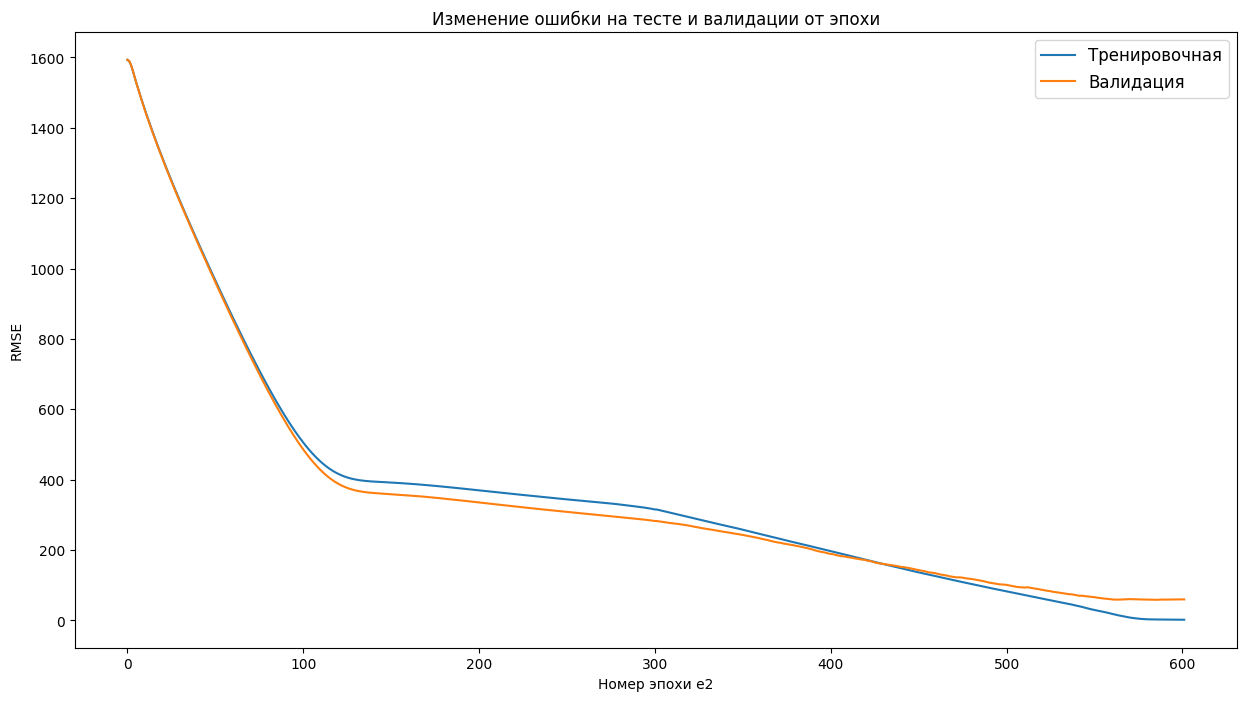

In [495]:
x = np.array(range(0, len(L1_test)))
plt.figure(figsize=(15,8))
plt.title('Изменение ошибки на тесте и валидации от эпохи')
plt.xlabel('Номер эпохи е2')
plt.ylabel('RMSE')
plt.plot(x,L1_train,label='Тренировочная')
plt.plot(x,L1_test,label='Валидация')
plt.legend(loc='best', fontsize=12)
plt.show()

In [493]:
num_epochs = 30000
for epoch in range(num_epochs):
    net1.train()
    optimizer.zero_grad()
    
    preds = net1.forward(X_train_tns).flatten()
    loss_value = torch.sqrt(loss(preds, Y_train_tns))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs-1:
        print(epoch)
        L1_train.append(loss_value.detach().numpy())
        net1.eval()
        vall_pred = net1.forward(X_vall_tns).flatten()
        L1 = torch.sqrt(loss(vall_pred,Y_vall_tns))
        L1_test.append(L1.detach().numpy())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [494]:
MAE(Y_vall, net1.forward(X_vall_tns).flatten().detach())

26.44654055359543

Номер сети: 0
Номер сети: 1
Номер сети: 2
Номер сети: 3
Номер сети: 4
Номер сети: 5
Номер сети: 6
Номер сети: 7
Номер сети: 8
Номер сети: 9


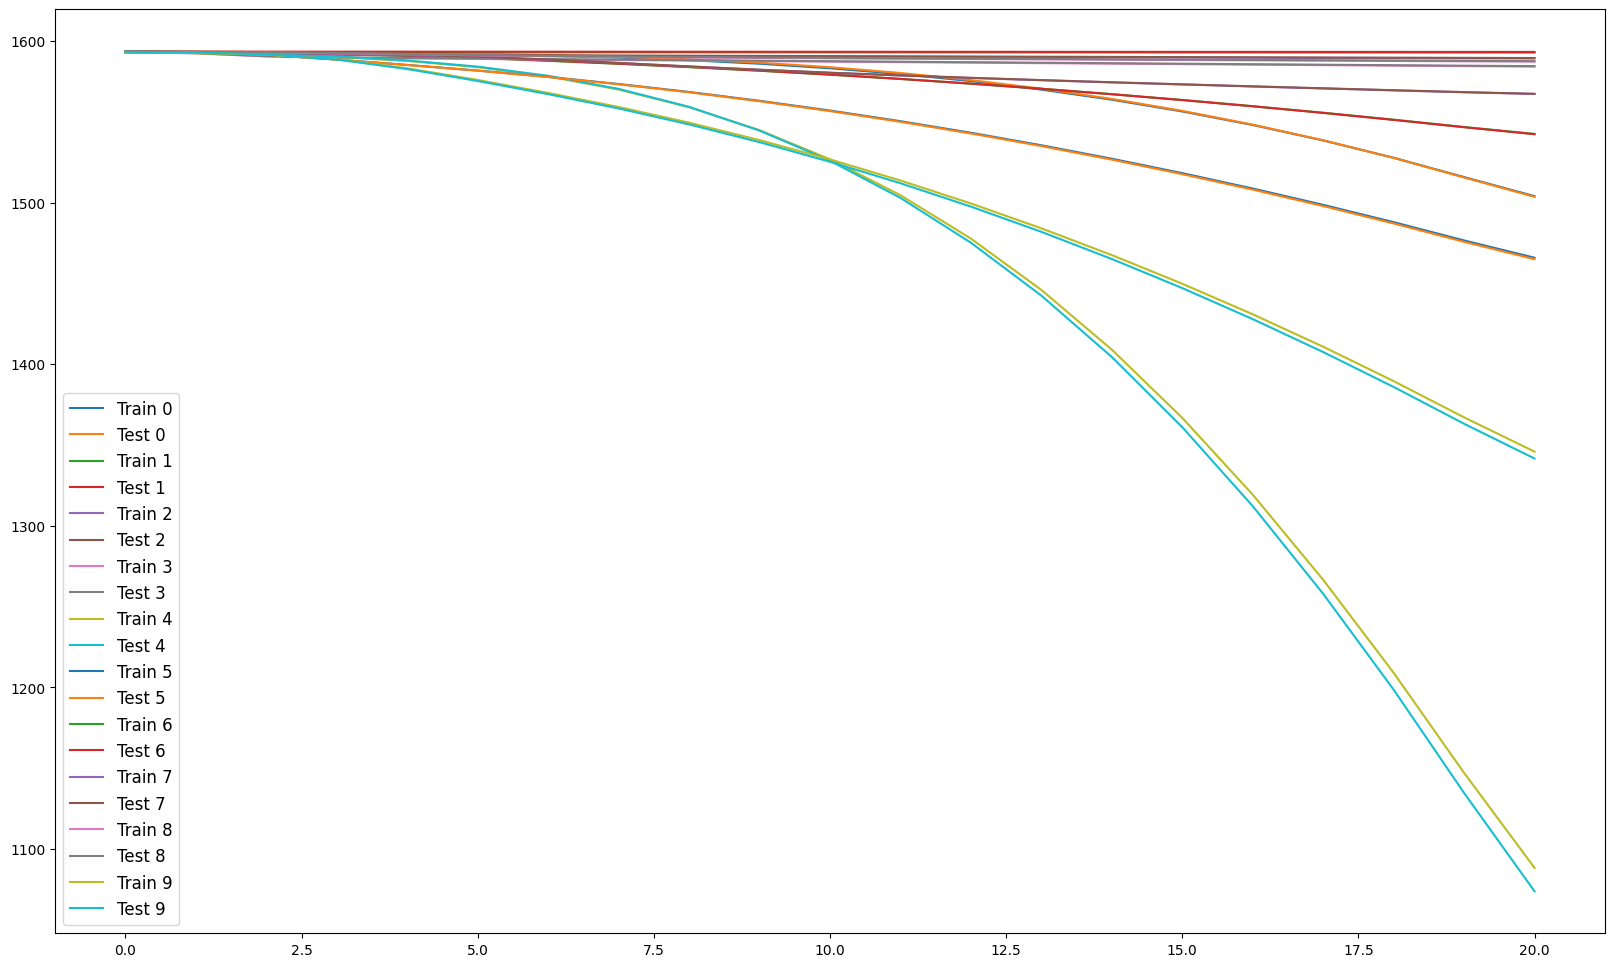

Номер сети: 10
Номер сети: 11
Номер сети: 12
Номер сети: 13
Номер сети: 14
Номер сети: 15
Номер сети: 16
Номер сети: 17
Номер сети: 18
Номер сети: 19


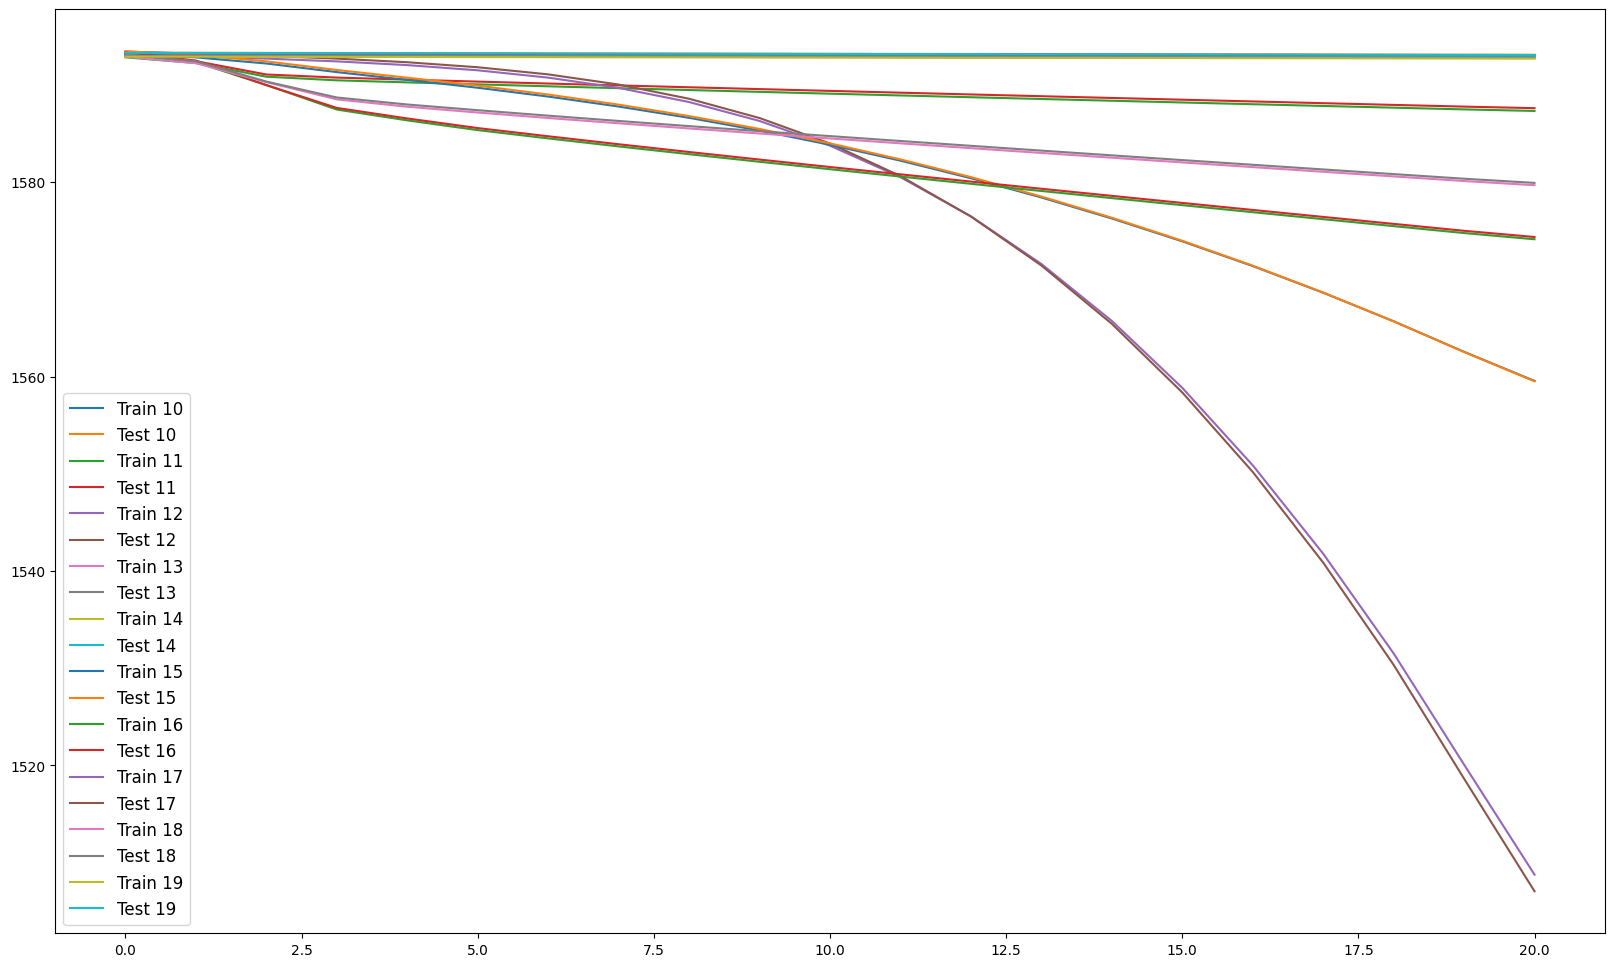

Номер сети: 20
Номер сети: 21
Номер сети: 22
Номер сети: 23
Номер сети: 24
Номер сети: 25
Номер сети: 26
Номер сети: 27
Номер сети: 28
Номер сети: 29


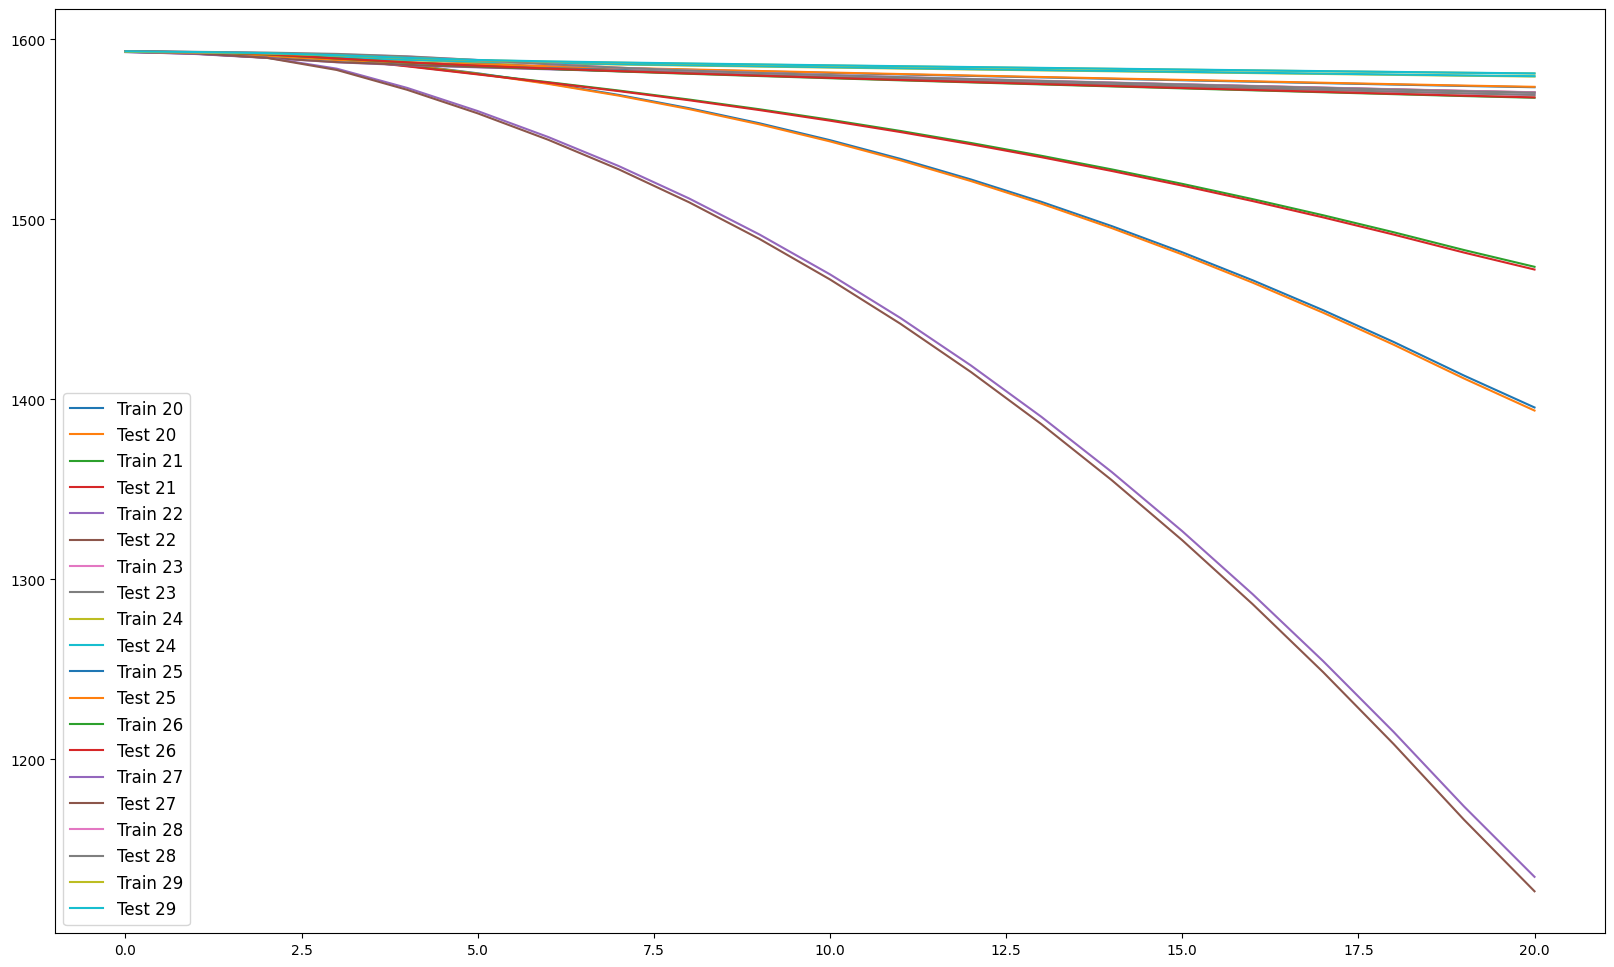

Номер сети: 30
Номер сети: 31
Номер сети: 32
Номер сети: 33
Номер сети: 34
Номер сети: 35
Номер сети: 36
Номер сети: 37
Номер сети: 38
Номер сети: 39


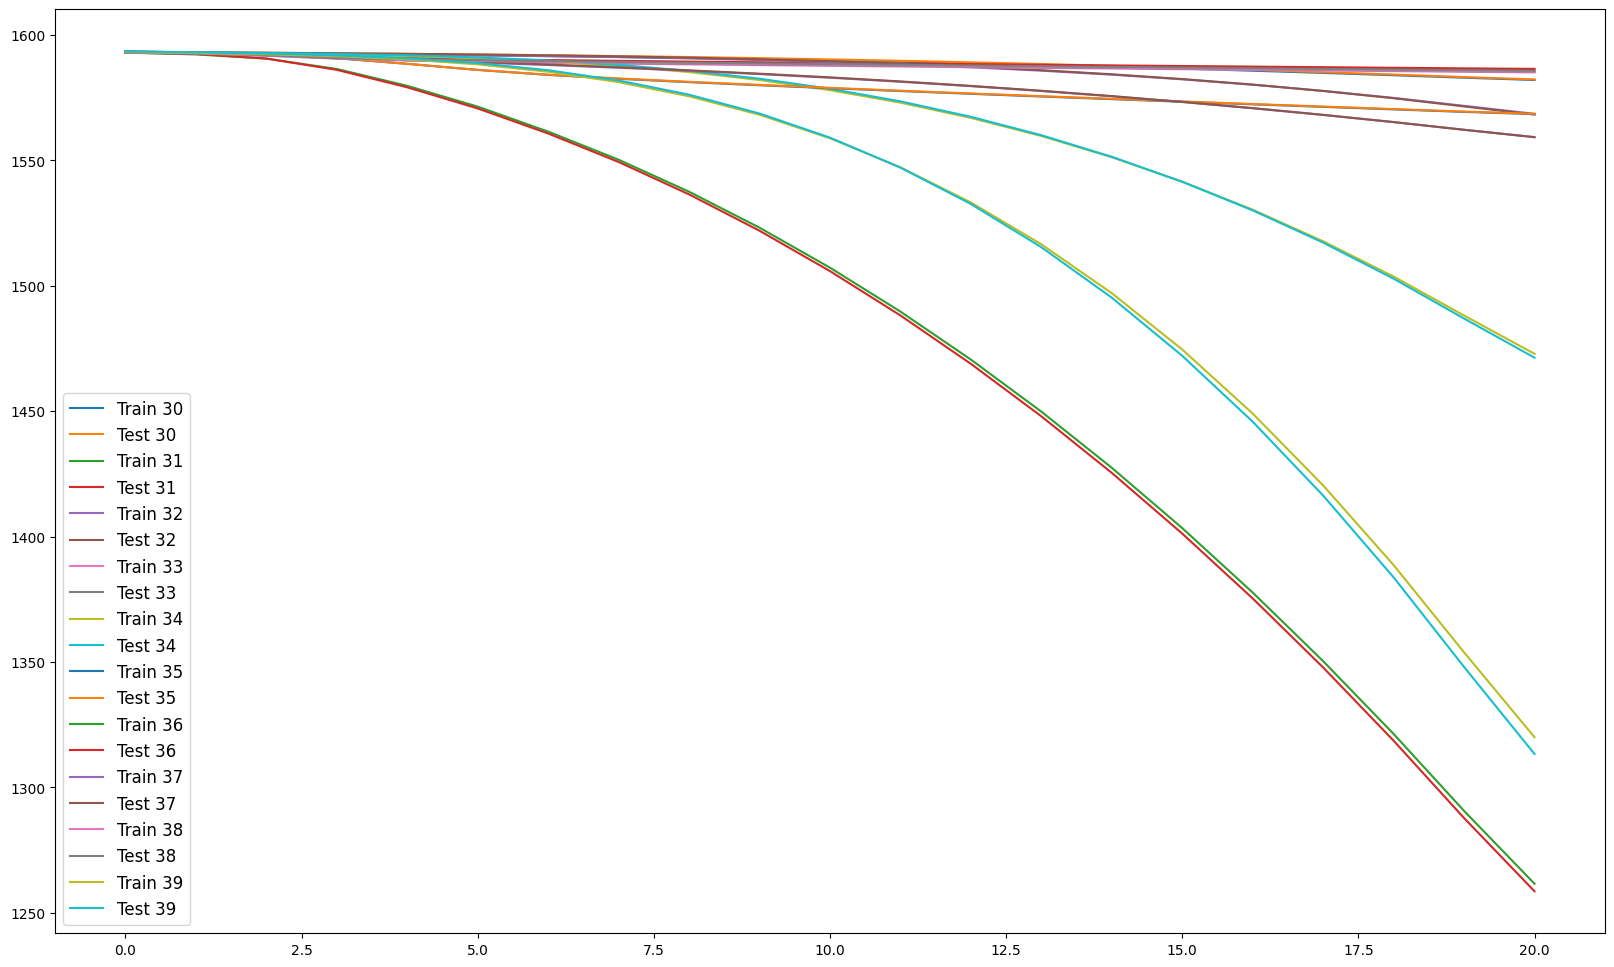

Номер сети: 40
Номер сети: 41
Номер сети: 42
Номер сети: 43
Номер сети: 44
Номер сети: 45
Номер сети: 46
Номер сети: 47
Номер сети: 48
Номер сети: 49


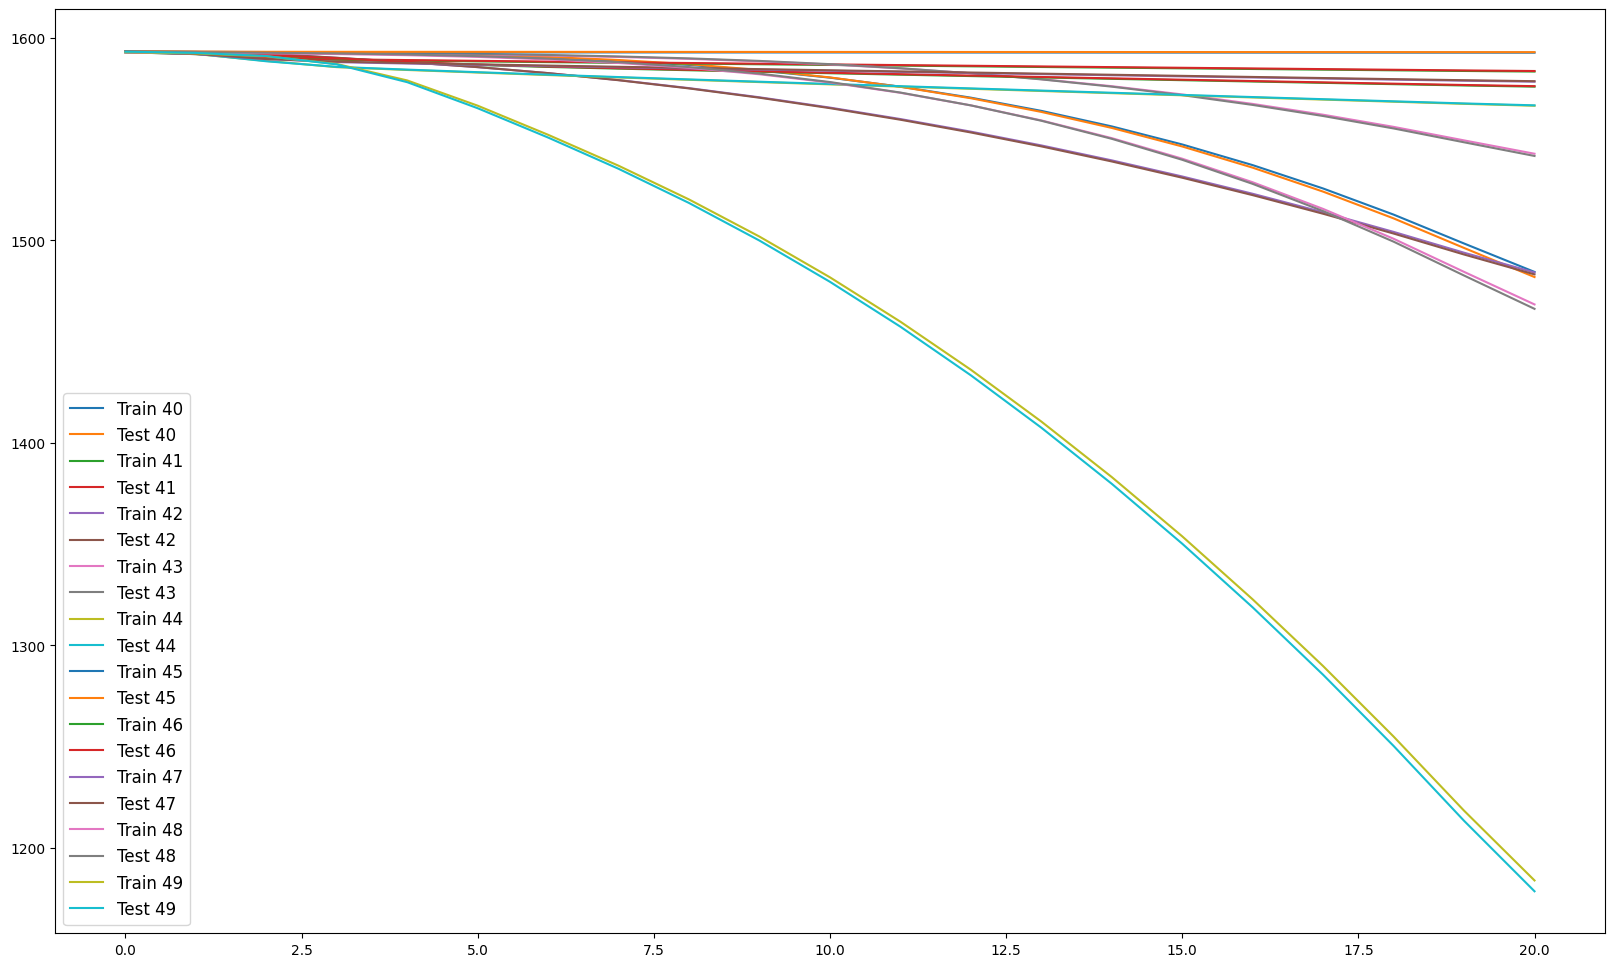

Номер сети: 50
Номер сети: 51
Номер сети: 52
Номер сети: 53
Номер сети: 54
Номер сети: 55
Номер сети: 56
Номер сети: 57
Номер сети: 58
Номер сети: 59


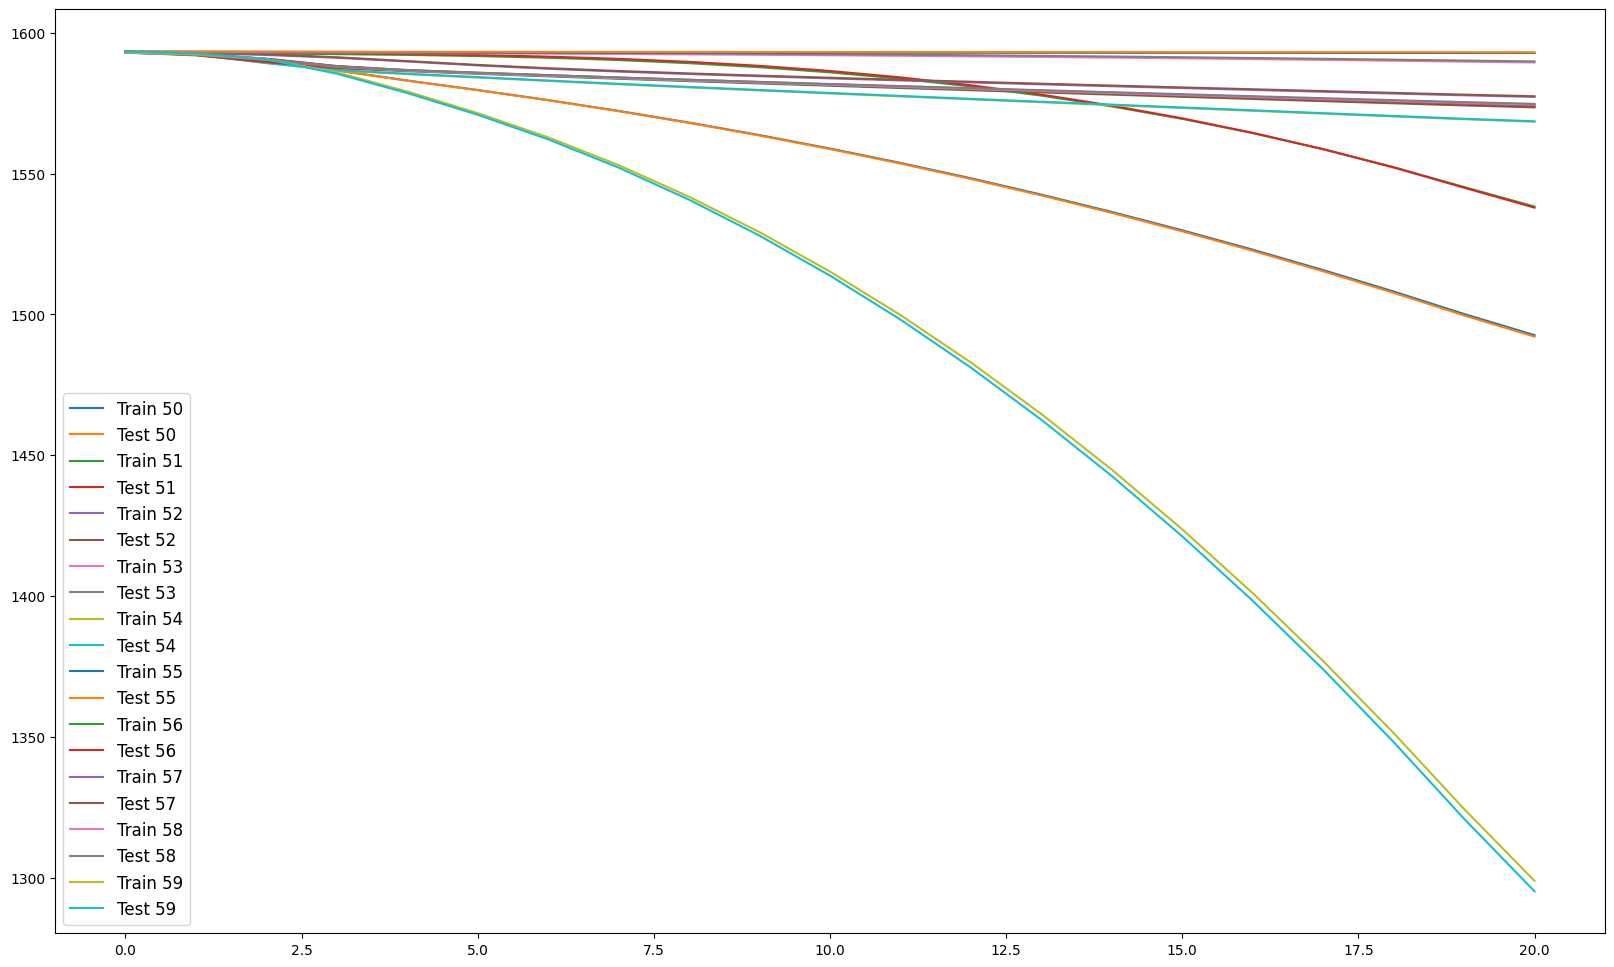

Номер сети: 60
Номер сети: 61
Номер сети: 62
Номер сети: 63
Номер сети: 64
Номер сети: 65
Номер сети: 66
Номер сети: 67
Номер сети: 68
Номер сети: 69


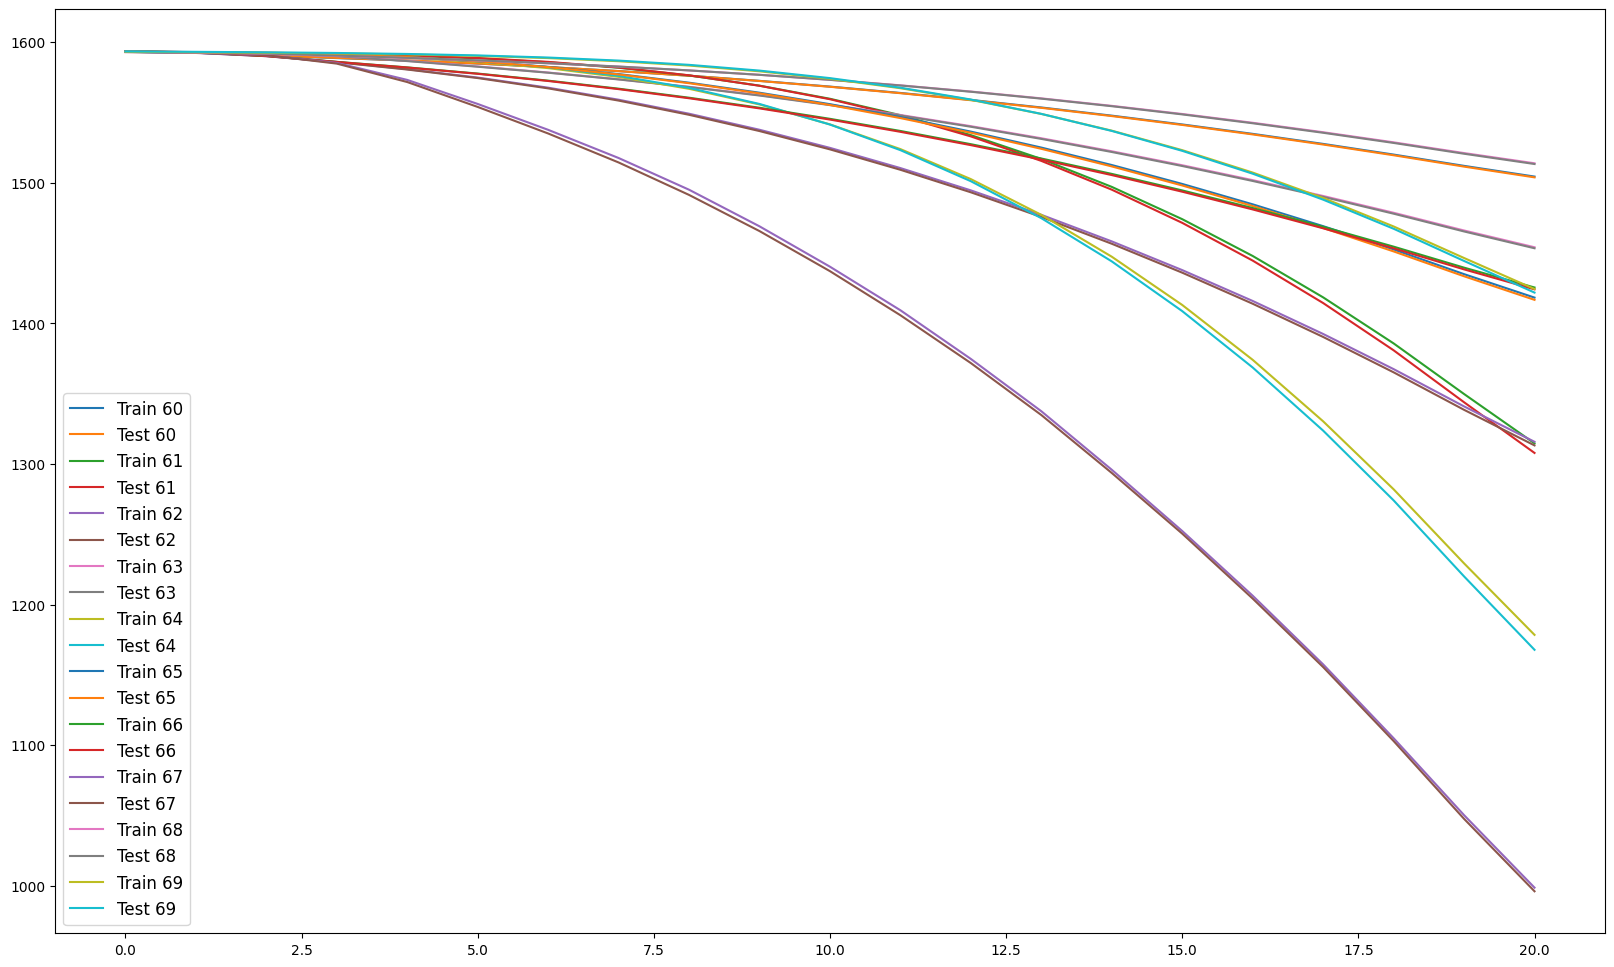

Номер сети: 70
Номер сети: 71
Номер сети: 72
Номер сети: 73
Номер сети: 74
Номер сети: 75
Номер сети: 76
Номер сети: 77
Номер сети: 78
Номер сети: 79


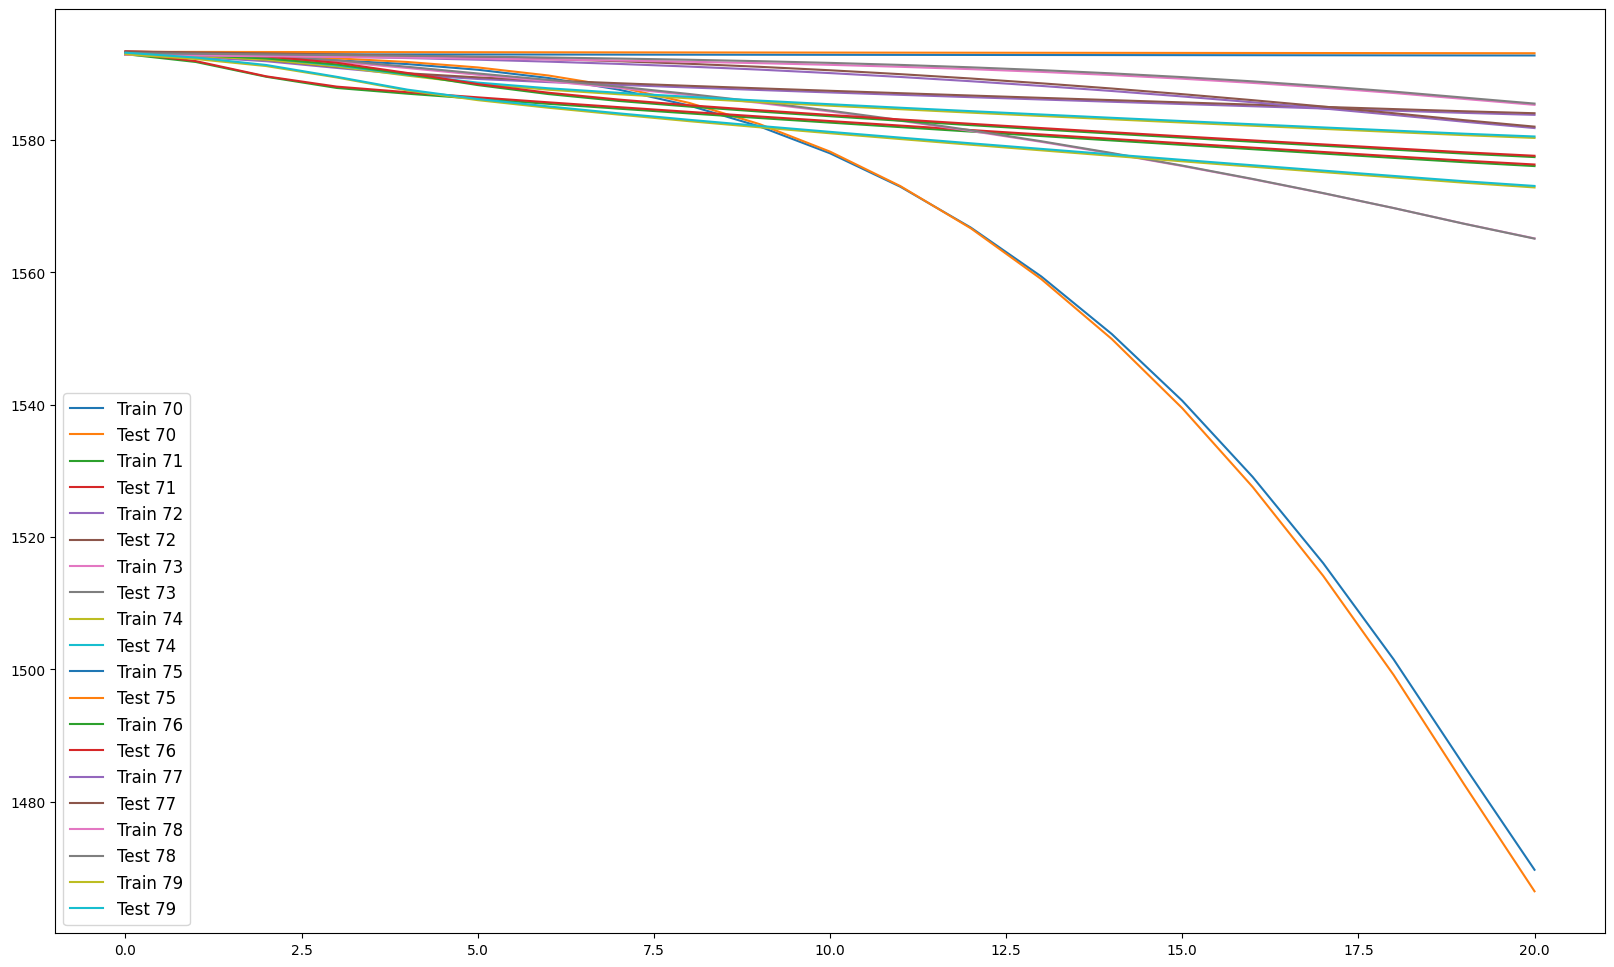

Номер сети: 80
Номер сети: 81
Номер сети: 82
Номер сети: 83
Номер сети: 84
Номер сети: 85
Номер сети: 86
Номер сети: 87
Номер сети: 88
Номер сети: 89


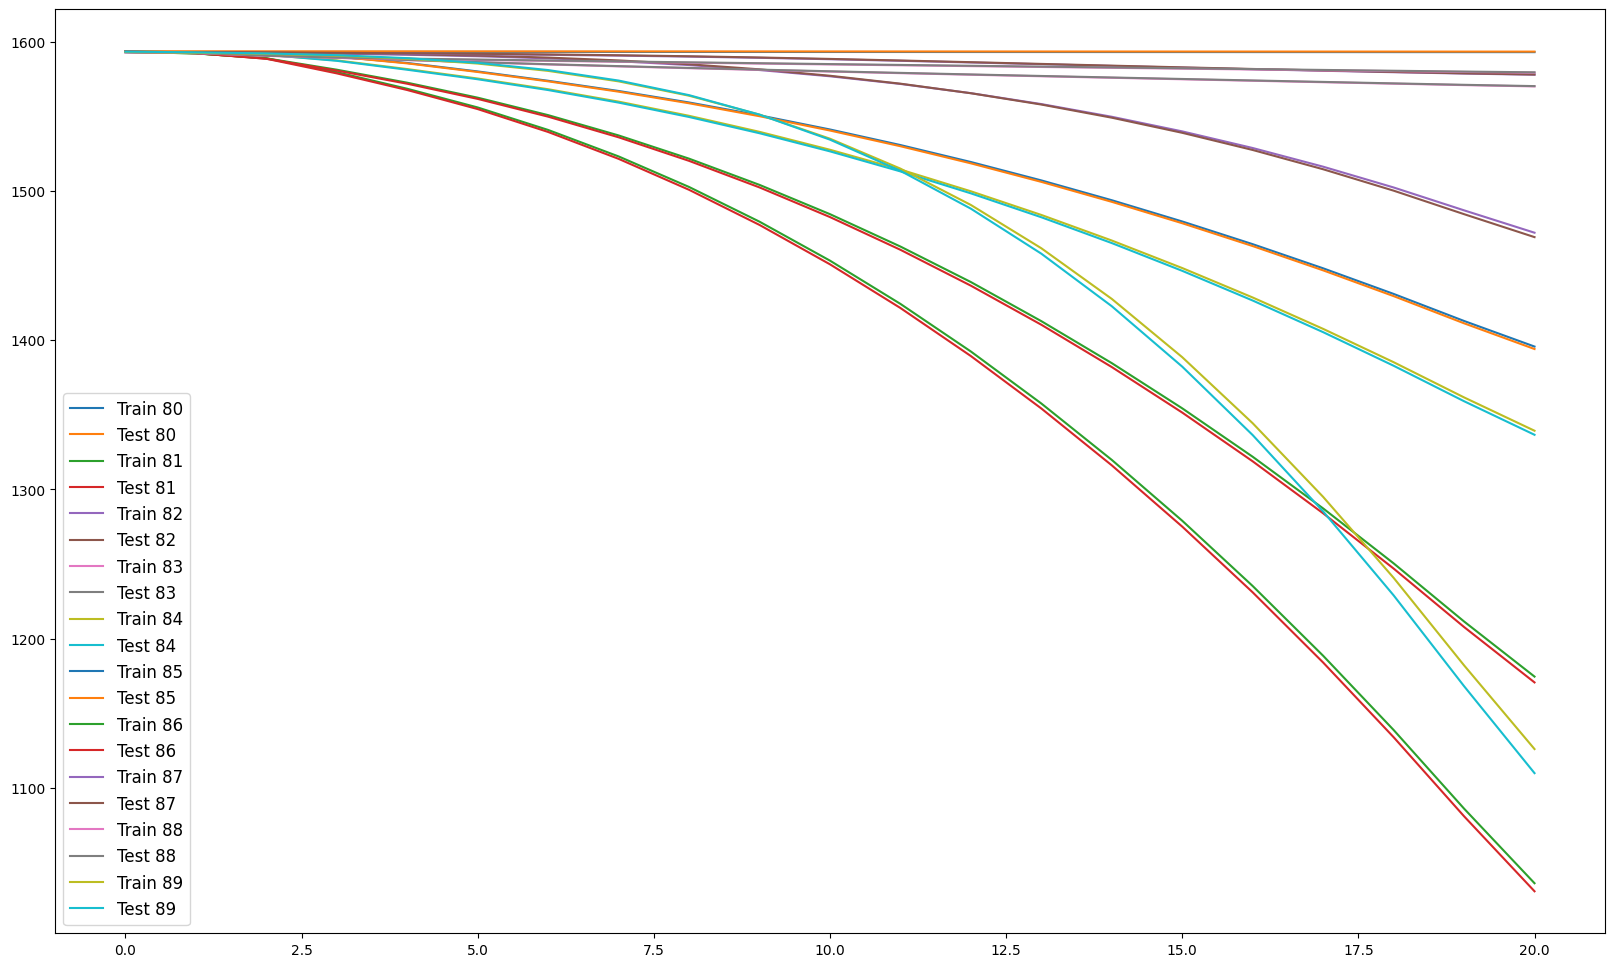

Номер сети: 90
Номер сети: 91
Номер сети: 92
Номер сети: 93
Номер сети: 94
Номер сети: 95
Номер сети: 96
Номер сети: 97
Номер сети: 98
Номер сети: 99


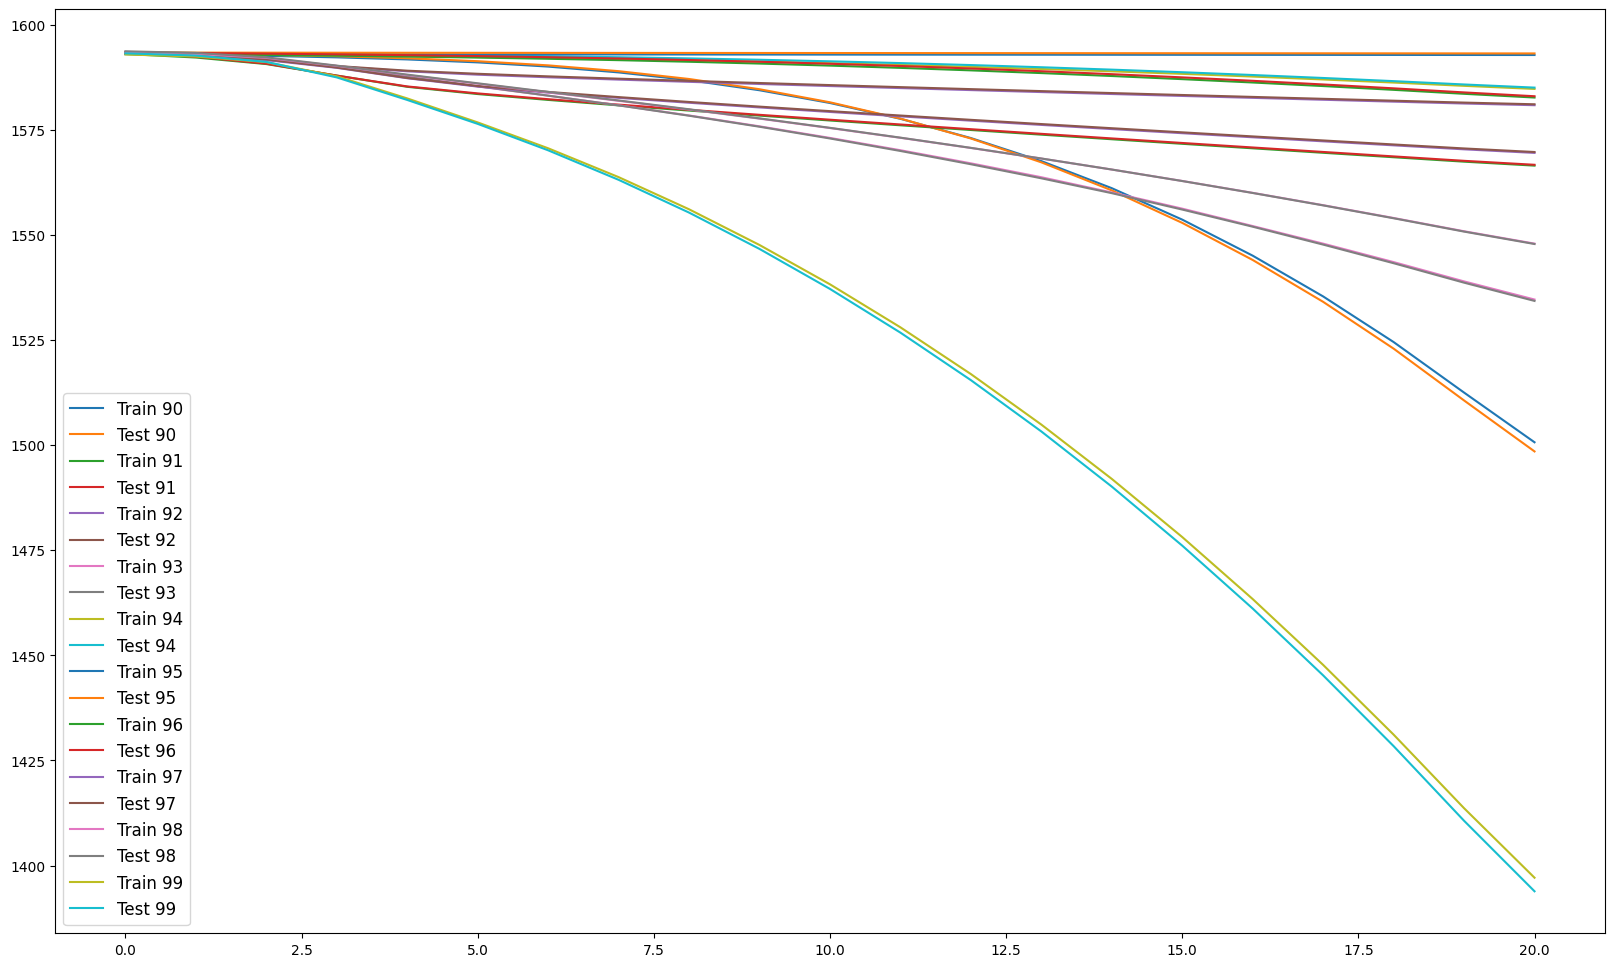

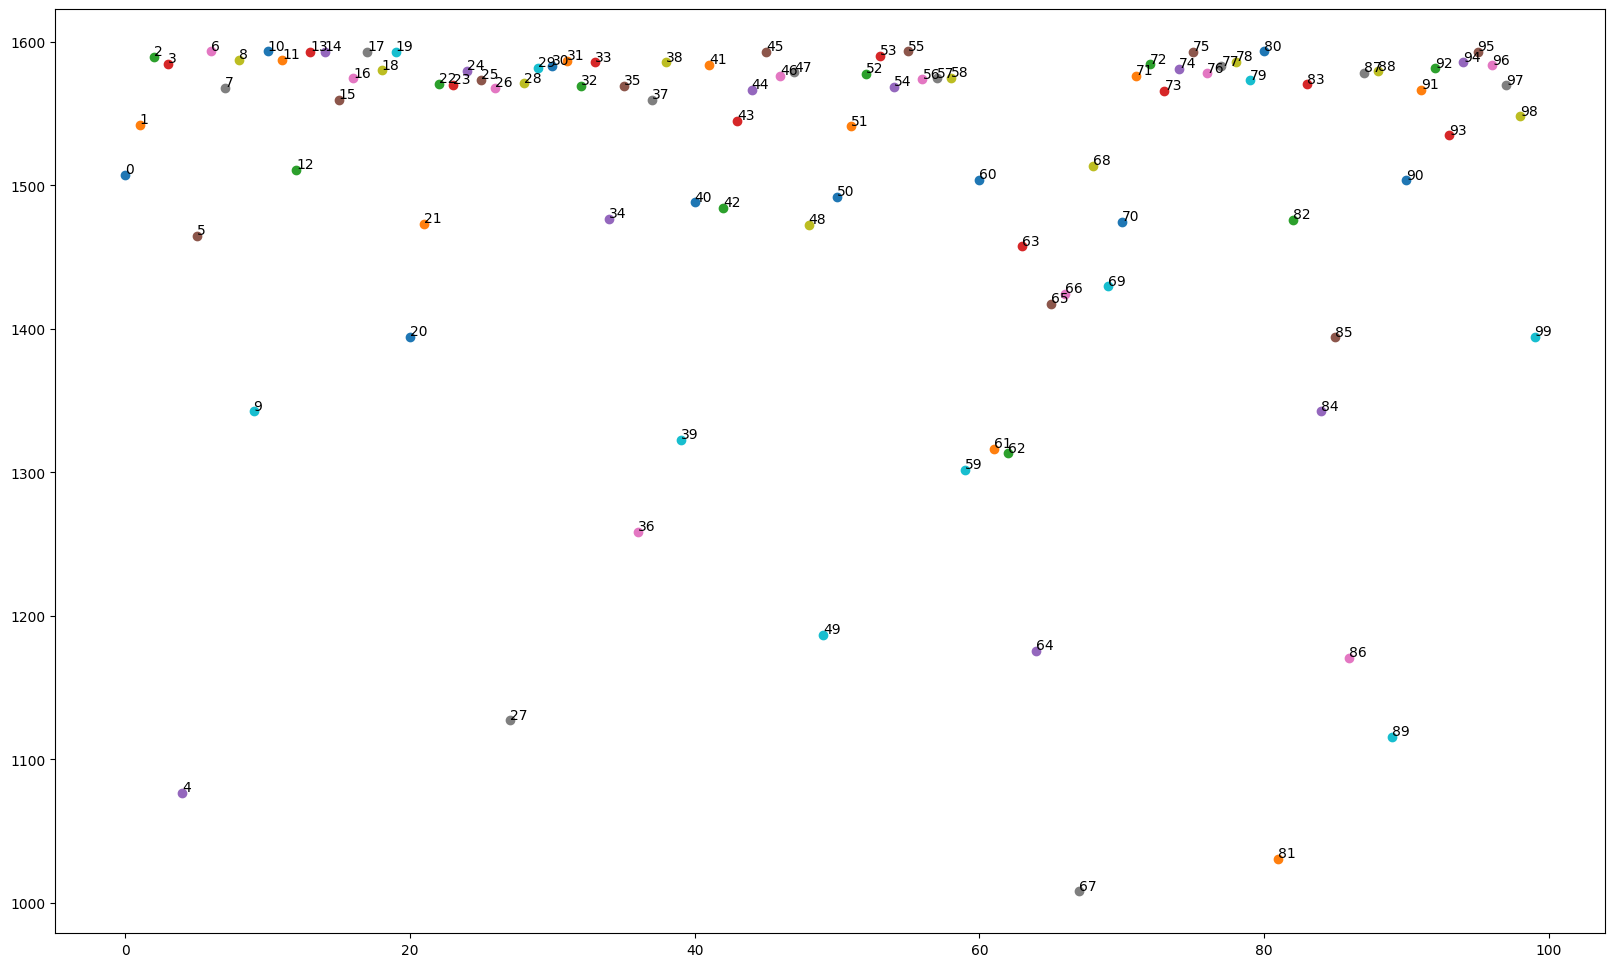

In [496]:
conf = []
for g in range(100):
    print(f'Номер сети: {g}')
    l = np.random.randint(0,8)
    n_neurons = [X_train_tns.shape[1]]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(2,100))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 200
    for epoch in range(num_epochs):
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(X_train_tns).flatten()
        loss_value = torch.sqrt(loss(preds, Y_train_tns))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            vall_pred = net1.forward(X_vall_tns).flatten()
            L1 = torch.sqrt(loss(vall_pred,Y_vall_tns))
            L1_test.append(L1.detach().numpy())
    rmse = MAE(Y_test_tns.detach(), net1.forward(X_test_tns).flatten().detach())
    conf[g].append(rmse)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
         plt.figure(figsize=(20,12))
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])

In [497]:
pd.DataFrame(conf).sort_values([2])

,0,1,2
67,67,"[31, 70, 43, 88, 63, 1]",1008.100830
81,81,"[31, 80, 36, 38, 71, 76, 72, 1]",1030.805298
4,4,"[31, 87, 99, 1]",1076.691284
89,89,"[31, 95, 85, 1]",1115.550293
27,27,"[31, 64, 77, 16, 26, 92, 47, 1]",1127.207642
...,...,...,...
17,17,"[31, 1]",1593.187622
10,10,"[31, 1]",1593.213501
6,6,"[31, 1]",1593.216309
55,55,"[31, 1]",1593.261597


Номер сети: 0
Номер сети: 1
Номер сети: 2
Номер сети: 3
Номер сети: 4
Номер сети: 5
Номер сети: 6
Номер сети: 7
Номер сети: 8
Номер сети: 9


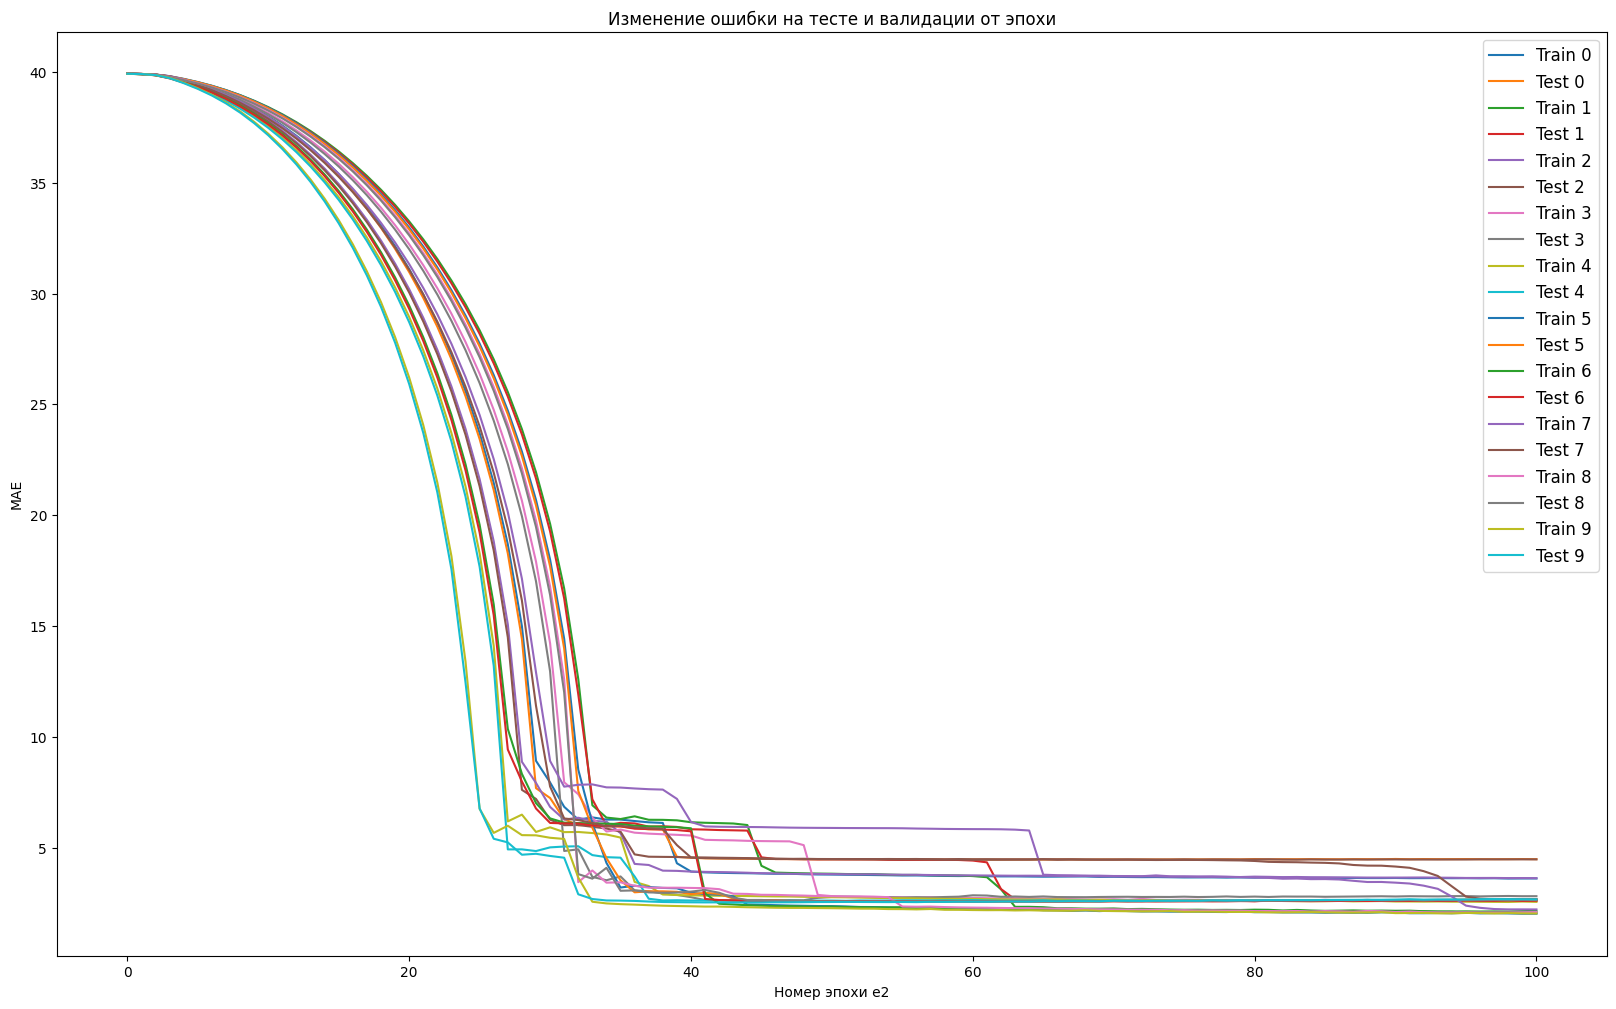

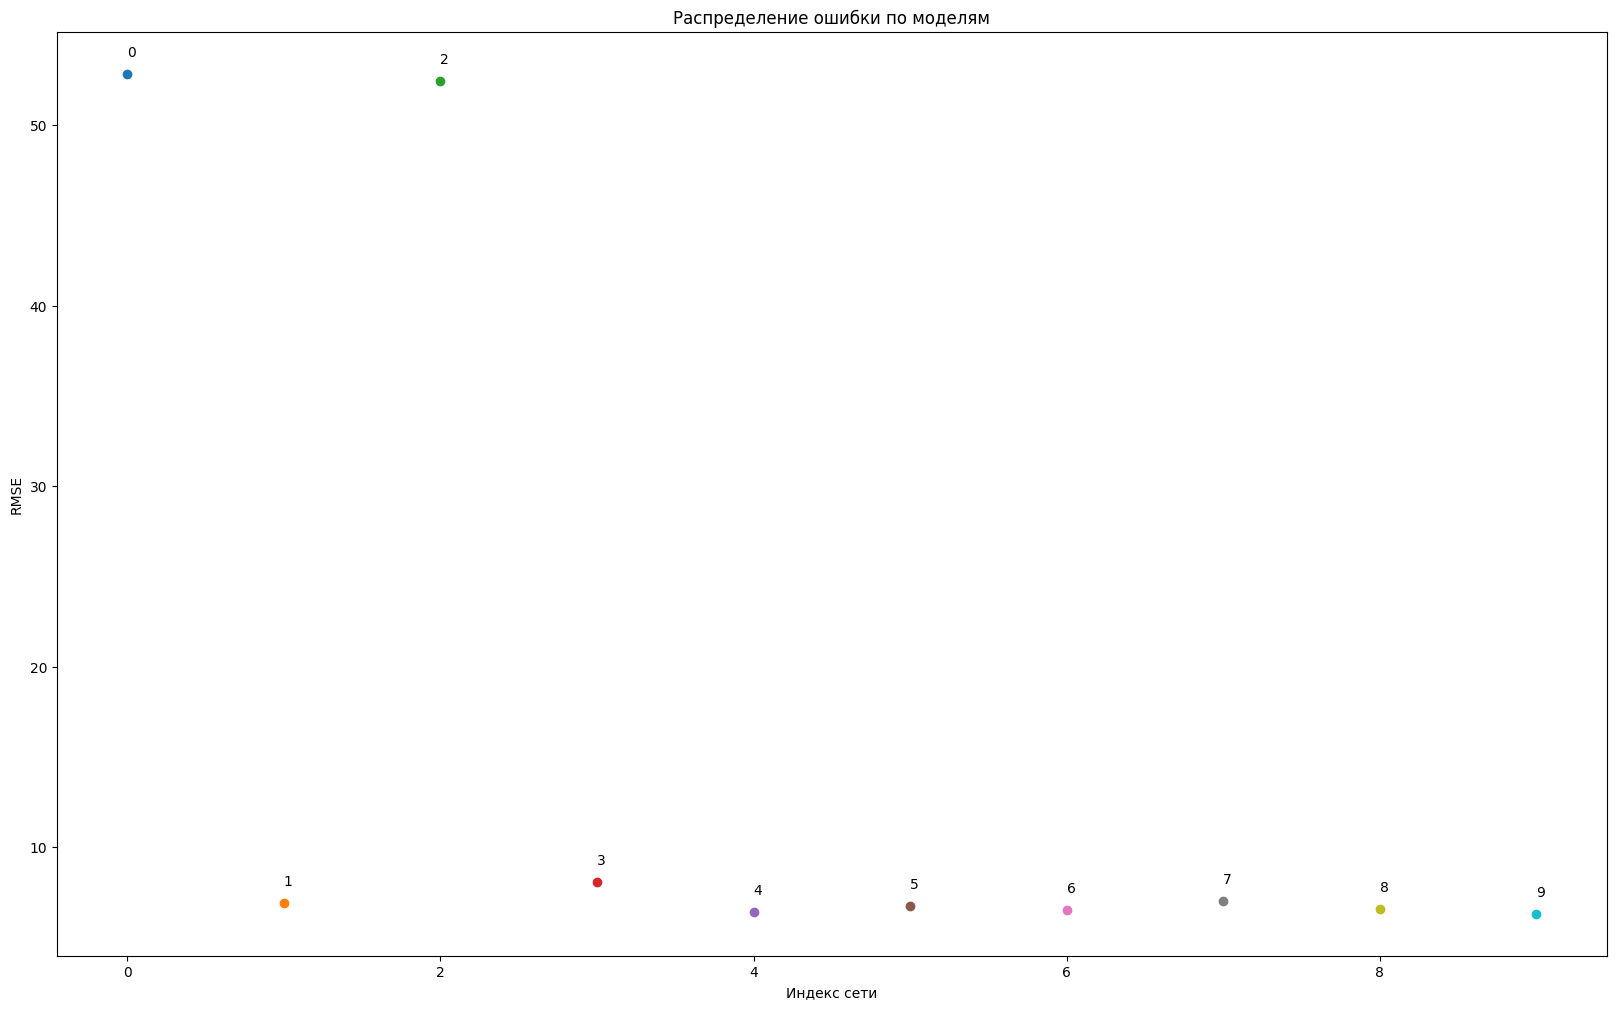

In [498]:
conf = []
for g in range(10):
    print(f'Номер сети: {g}')
    l = 4
    n_neurons = [X_train_tns.shape[1]]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(50,100))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.L1Loss()

    num_epochs = 1000
    for epoch in range(num_epochs):
        #if epoch % 10 == 0: print(f'Номер эпохт: {epoch}')
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(X_train_tns).flatten()
        loss_value = torch.sqrt(loss(preds, Y_train_tns))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            vall_pred = net1.forward(X_vall_tns).flatten()
            L1 = torch.sqrt(loss(vall_pred,Y_vall_tns))
            L1_test.append(L1.detach().numpy())
    rmse = MAE(Y_test_tns.detach(), net1.forward(X_test_tns).flatten().detach())
    conf[g].append(rmse)
    conf[g].append(net1)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
        plt.figure(figsize=(20,12))
        plt.title('Изменение ошибки на тесте и валидации от эпохи')
        plt.xlabel('Номер эпохи е2')
        plt.ylabel('MAE')
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])
plt.show()

In [499]:
pd.DataFrame(conf).sort_values([2])

,0,1,2,3
9,9,"[31, 83, 69, 95, 88, 1]",6.312181,"[Linear(in_features=31, out_features=83, bias=..."
4,4,"[31, 50, 81, 98, 70, 1]",6.418329,"[Linear(in_features=31, out_features=50, bias=..."
6,6,"[31, 77, 94, 89, 76, 1]",6.516206,"[Linear(in_features=31, out_features=77, bias=..."
8,8,"[31, 75, 86, 59, 82, 1]",6.563217,"[Linear(in_features=31, out_features=75, bias=..."
5,5,"[31, 86, 79, 57, 83, 1]",6.721164,"[Linear(in_features=31, out_features=86, bias=..."
1,1,"[31, 76, 73, 60, 77, 1]",6.887118,"[Linear(in_features=31, out_features=76, bias=..."
7,7,"[31, 58, 52, 86, 65, 1]",6.999381,"[Linear(in_features=31, out_features=58, bias=..."
3,3,"[31, 62, 85, 94, 54, 1]",8.059977,"[Linear(in_features=31, out_features=62, bias=..."
2,2,"[31, 81, 60, 83, 76, 1]",52.426113,"[Linear(in_features=31, out_features=81, bias=..."
0,0,"[31, 99, 78, 78, 76, 1]",52.838531,"[Linear(in_features=31, out_features=99, bias=..."


In [500]:
best_net = conf[9][3]
MAE(Y_vall_tns.detach(), best_net.forward(X_vall_tns).flatten().detach())

7.135393

## Выбор лушей модели

In [501]:
pd.DataFrame({'Model':['Forest','CatBoost','Net'],
              'MAE':[MAE(Y_vall, rfr.predict(X_vall)),
                    MAE(Y_vall,model_cbr.predict(X_vall)),
                    MAE(Y_vall_tns.detach(), best_net.forward(X_vall_tns).flatten().detach())]})

,Model,MAE
0,Forest,6.732829
1,CatBoost,6.603450
2,Net,7.135393


In [502]:
MAE(Y_test,model_cbr.predict(X_test))

6.092542069682119